# eBay Assistant v2 | Development Notebook

In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import asyncio
import nest_asyncio
from PIL import Image as PILImage
from IPython.display import Markdown, display, Image, HTML

os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from typing import List, Dict, Any
import uuid
from urllib.parse import urlparse
import base64
import lancedb
import instructor
import openai
from marvin.beta.assistants import Assistant, Thread
from marvin.beta.assistants.formatting import pprint_messages, pprint_run

In [3]:
from src.utils import llm
from src.doc_store.ebay_scraper import eBayWebSearch, AverageSalePrice
from src.doc_store.ebay_utils import (
    process_ebay_images_with_async,
    deduplicate_products,
    deduplicate_search_items,
    download_and_save_images, 
    plot_images,
    eBayItems,
)

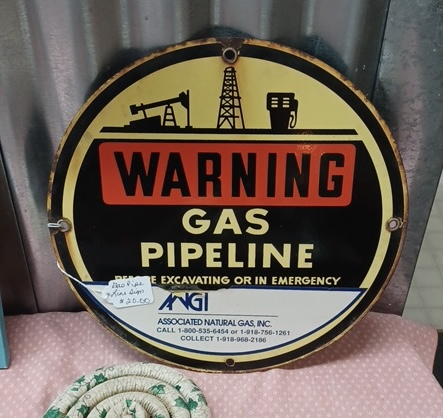

In [4]:
new_image = "ebay_item.jpg"
display(Image(filename=new_image))

In [5]:
from src.doc_store.ebay_utils import process_ebay_images_with_threadpool


def search_image_vectors(image_path: str, df: pd.DataFrame, n: int = 10) -> List[eBayItems]:
    unique_table_name = f"ebay_{uuid.uuid4().hex}"
    unique_table_name = "test_table"
    db = lancedb.connect("./.lancedb")
    table = db.create_table(unique_table_name, schema=eBayItems, mode='overwrite')
    table.add(df)
    query_image = PILImage.open(image_path)
    res = table.search(query_image) \
        .limit(n) \
        .to_pydantic(eBayItems)
    db.drop_table(unique_table_name)
    return res

def get_similar_listings(search_query: str, image_path: str, n: int = 5, sold: bool=True) -> List[eBayItems]:
    """
    Searches for similar eBay listings based on a query and an image.

    Args:
        search_queries (List[str]): A list of search queries.
        image_path (str): The path to the image for similarity search.
        n (int): Number of image results per search query after sorting by image similarity.

    Returns:
        List[eBayItems]: A list of the best matching listings based on image similarity.
    """
    print(f"Searching for {search_query}...")
    search_results = eBayWebSearch(search_query, alreadySold=sold)
    process_ebay_images_with_threadpool(search_results)
    search_results = deduplicate_products(search_results)
    print(f"Top **{n}** matches based on analysis of **{len(search_results):,}** listings:")
    df = pd.DataFrame([r.to_data_dict for r in search_results])
    best_images = search_image_vectors(image_path, df, n)

    return best_images

In [9]:
search_results = eBayWebSearch(query=" Vintage Gas Pipeline Warning Sign", alreadySold=True)

In [10]:
process_ebay_images_with_threadpool(search_results)
len(search_results)

60

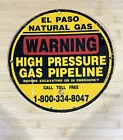

In [11]:
search_results[2].image

In [12]:
df = pd.DataFrame([r.to_data_dict for r in search_results])
image_path = "ebay_item.jpg"

best_images = search_image_vectors(image_path, df, 10)

100%|██████████| 60/60 [00:02<00:00, 29.84it/s]


In [47]:
best_images

[eBayItems(id='226020546592', text='eBay\nAppleton Electric Company A-51 GRF Explosion Proof Light\nFixture 300 V 200 W VTG\nUsed working condition. Removed from working service environment. Industrial surplus.\nItem pictured is the exact item you will receive, unless multiple quantities available.\nMost items ship same day or next day of payment received from North Carolina.\nUPS Next Day Air orders will ship same day if paid before 3:00PM EST', vector=FixedSizeList(dim=512), image_uri='data\\multimodal\\Appleton_Electric_Company_A-51_GRF_Explosion_Proof_Light_Fixture_300_V_200_W_VTG.jpg', title='Appleton Electric Company A-51 GRF Explosion Proof Light\tFixture 300 V 200 W VTG', price='$50.00', image_base64='UklGRoYFAABXRUJQVlA4IHoFAADQHQCdASppAIwAPm00lUgkIqIhI5kq2IANiWcA1RAWKfs86futArirH97ptXCNG8d2oN+t3WdJVxMcMj7iJWxRu7hotLd87yZzisKgHKkxgl+3bb0o2DXyLd5pmd7CkQfTSW7dSX3wf74+j5n3DF61uCFXDSDJMzVI7sP4JWPFAXkTi0cWf7t9jLFfySZIWNjNMdXyIA39qXVclCqu5lm/4Tn/dGDv55XaotUDwLOuRJAZevlz5sujH51qh5k48

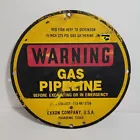

In [20]:
best_images[7].image

In [5]:
def thumbnail(image, scale=3):
    return image.resize(np.array(image.size)//scale)

def safe_get(data, dot_chained_keys):
    """
    {'a': {'b': [{'c': 1}]}}
    safe_get(data, 'a.b.0.c') -> 1
    """
    keys = dot_chained_keys.split(".")
    for key in keys:
        try:
            if isinstance(data, list):
                data = data[int(key)]
            else:
                data = data[key]
        except (KeyError, TypeError, IndexError):
            return None
    return data


def response_parser(response: Dict[str, Any]):
    return safe_get(response, "choices.0.message.content")


def is_url(image_path: str) -> bool:
    """
    Check if the given string is a valid URL.

    Args:
        image_path (str): The string to check.

    Returns:
        bool: True if the string is a valid URL, False otherwise.
    """
    try:
        result = urlparse(image_path)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False
    
    
def encode_image_to_base64(image_path: str) -> str:
    """
    Encode a local image file to a base64 string.

    Args:
        image_path (str): The path to the image file.

    Returns:
        str: The base64 encoded string of the image.
    """
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


prompt_text_single_image = (
    "You are a highly knowledgeable eBay power seller. "
    "Your task is to examine the following image in detail. "
    "Begin with a descriptive title caption using level one markdown heading. "
    "Provide a comprehensive, factual, and price-focused explanation of what the image depicts. "
    "Highlight key elements and their significance, and present your analysis in clear, well-structured markdown format. "
    "If applicable, include any relevant facts to enhance the explanation. "
    "TITLE: "
)

prompt_text_multi_image = (
    "You are a highly knowledgeable eBay power seller. "
    "Your task is to examine the following set of images in detail, which are all of the same item. "
    "Begin with a descriptive title caption using level one markdown heading. "
    "Provide a comprehensive, factual, and price-focused explanation of what the image depicts. "
    "Highlight key elements and their significance, and present your analysis in clear, well-structured markdown format. "
    "If applicable, include any relevant facts to enhance the explanation. "
    "TITLE: "
)


def dynamic_prompt_selection(image_paths: List[str]) -> str:
    """
    Selects the appropriate prompt based on the number of images provided by the user.

    Args:
        image_paths (List[str]): A list of URLs or local paths for the images.

    Returns:
        str: The selected prompt text.
    """
    if len(image_paths) > 1:
        return prompt_text_multi_image
    else:
        return prompt_text_single_image


def inspect_images(image_paths: str, prompt_text: str, additional_details: str) -> str:
    
    prompt_text += f"\n\nAdditional Context or Instructions Provided by the User:\n{additional_details}"
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
            ] + [
                {"type": "image_url", "image_url": {"url": path} if is_url(path) else f"data:image/jpeg;base64,{encode_image_to_base64(path)}"}
                for path in image_paths
            ],
        }
    ]
    client = openai.OpenAI()

    response = client.chat.completions.create(
        model="gpt-4-vision-preview", messages=messages
    )

    initial_inspection = response_parser(response.model_dump())
    return initial_inspection

In [22]:
image_paths = ["ebay_item.jpg"]
prompt_text = dynamic_prompt_selection(image_paths)

initial_inspection = inspect_images(image_paths, prompt_text, additional_details=None)

Markdown(initial_inspection)

# Vintage Gas Pipeline Warning Sign

This image depicts a vintage warning sign that is likely to have been used to mark the location of a gas pipeline. Below is a detailed analysis of the sign's features and potential value:

## Visual Description:
- **Color Scheme:** The sign features a striking color contrast with a black background, bold yellow border, and red typeface, which are colors traditionally used for high visibility and to denote caution.
- **Typography:** The word "WARNING" is prominently displayed in large, uppercase letters, indicating the importance of the information provided.
- **Graphics:** Below the warning text, there is an illustration of a gas well tower and construction machinery, which visually communicates the type of infrastructure associated with the pipeline.
- **Company Logo:** At the bottom, the sign includes the name ASSOCIATED NATURAL GAS INC., which is a specific identifier likely linked to the company that operated the gas pipeline.
- **Contact Information:** It provides contact numbers that would have been used for excavating or in emergency situations, adding to its authenticity as a functional industrial sign.

## Significance:
- **Collectibility & Market:** Vintage and antique signage is a popular category among collectors, especially items that have industrial, transportation, or petroleum history relevance.
- **Condition:** The condition of the sign affects its value. In the image, the sign shows some wear, particularly around the edges. This patina could be seen as a desirable feature for age authenticity or as a detractor from its condition.
- **Authenticity and Age:** The style of the sign, including font and design, can suggest its age. The phone number format with a collect call notice indicates a pre-1990s era, potentially increasing the sign's value as a collectible item.

## Pricing Analysis:
Given these factors, the value could vary considerably and would need to be assessed based on:
- **Demand:** Interest in the particular company or type of sign.
- **Rarity:** How many of these signs have survived and are available in the market.
- **Comparables:** Prices of similar signs sold or currently for sale.

Without a current market assessment, it's difficult to provide an exact price, but warning signs like this could typically range anywhere from $50 to $300, depending on the factors mentioned above.

## Conclusion:
This warning sign is not only a piece of functional industrial history but also could be a desirable artifact for specific collectors. With the history of the company and rarity of the sign considered, it could attract bidders looking for unique additions to their collections or for decor purposes in themed environments, such as a restaurant or bar. To maximize value, the seller should highlight the sign's authenticity, age, and potential historical significance in a listing.

In [23]:
import instructor
from pydantic import BaseModel, Field
from tenacity import Retrying, stop_after_attempt, wait_fixed

class eBayQueryList(BaseModel):
    """A eBay item that is being searched."""
    
    item_name: str = Field(
        ...,
        description="A concise, but descriptive name for the item of interest."
    )
    search_queries: List[str] = Field(
        default_factory=list,
        description="A diverse list of alternative eBay search queries that compliment the primary item of interest."
    )
    
    @property
    def search_tasks(self):
        alternates = [query for query in self.search_queries]
        search_tasks = [str(self.item_name)]
        search_tasks.extend(alternates)
        return search_tasks

    
def generate_base_queries(
    item_description: str, 
) -> eBayQueryList:
    client = instructor.from_openai(openai.OpenAI())
    return client.chat.completions.create_partial(
        model="gpt-4o",
        temperature=0.3,
        response_model=eBayQueryList,
        max_retries=Retrying(
            stop=stop_after_attempt(5),
            wait=wait_fixed(1),
        ),
        messages=[
            {
                "role": "system",
                "content": "You are a world class eBay assistant.",
            },
            {
                "role": "user",
                "content": f"The following is a detailed description of an item the user wants to buy on eBay. Take the description, and distill it down to concise, but descriptive name along with **2** diverse search queries for the item::\n\nITEM DESCRIPTION: {item_description}",
            },
        ],
        stream=True,
    )
    

In [24]:
base_queries = generate_base_queries(initial_inspection)

obj = None
for query in base_queries:
    obj = query.model_dump()
    print(obj)
    
search_query_result = eBayQueryList(**obj)

{'item_name': None, 'search_queries': []}
{'item_name': None, 'search_queries': []}
{'item_name': None, 'search_queries': []}
{'item_name': None, 'search_queries': []}
{'item_name': None, 'search_queries': []}
{'item_name': None, 'search_queries': []}
{'item_name': None, 'search_queries': []}
{'item_name': None, 'search_queries': []}
{'item_name': None, 'search_queries': []}
{'item_name': None, 'search_queries': []}
{'item_name': 'Vintage Gas Pipeline Warning Sign', 'search_queries': []}
{'item_name': 'Vintage Gas Pipeline Warning Sign', 'search_queries': []}
{'item_name': 'Vintage Gas Pipeline Warning Sign', 'search_queries': []}
{'item_name': 'Vintage Gas Pipeline Warning Sign', 'search_queries': []}
{'item_name': 'Vintage Gas Pipeline Warning Sign', 'search_queries': []}
{'item_name': 'Vintage Gas Pipeline Warning Sign', 'search_queries': []}
{'item_name': 'Vintage Gas Pipeline Warning Sign', 'search_queries': []}
{'item_name': 'Vintage Gas Pipeline Warning Sign', 'search_queries': 

In [25]:
search_query_result.search_tasks

['Vintage Gas Pipeline Warning Sign',
 'Vintage Industrial Gas Pipeline Sign',
 'Antique Gas Pipeline Warning Sign']

In [26]:
averagePrice = AverageSalePrice(
    query=search_query_result.search_tasks[0], 
    country='us', 
    condition='all',
)
Markdown(str(averagePrice))

Average Price (based on 56 sold items):

* Item: $41.42 ($1.8 to $139.37)

* Shipping: $10.24 ($5.15 to $15.5)

* Total: $51.66

In [28]:
from typing import List
import asyncio
from concurrent.futures import ThreadPoolExecutor
from transformers import CLIPTokenizerFast, CLIPModel, CLIPProcessor


def search_image_vectors(image_path: str, df: pd.DataFrame, n: int = 10) -> List[eBayItems]:
    # unique_table_name = f"ebay_{uuid.uuid4().hex}"
    unique_table_name = "test_table"
    db = lancedb.connect("./.lancedb")
    table = db.create_table(unique_table_name, schema=eBayItems, mode='overwrite')
    table.add(df)
    query_image = PILImage.open(image_path)
    res = table.search(query_image) \
        .limit(n) \
        .to_pydantic(eBayItems)
    # db.drop_table(unique_table_name)
    return res
      
        
async def get_similar_listings(search_queries: List[str], image_path: str, n: int = 10, sold: bool=True):
    """
    Asynchronously searches for similar eBay listings based on given queries and an image path.
    Processes images asynchronously and deduplicates products to find the best matches.

    Args:
        search_queries (List[str]): A list of search queries.
        image_path (str): The path to the image for similarity search.
        n (int): Number of image results per search query after sorting by image similarity.

    Returns:
        List: A list of the best matching listings based on image similarity.
    """
    async def process_search_query(query):
        print(f"Searching for {query}...")
        search_results = eBayWebSearch(query, alreadySold=sold)
        await process_ebay_images_with_async(search_results)
        search_results = deduplicate_products(search_results)
        print(f"Analyzing descriptions and images from {len(search_results)} listings...")
        df = pd.DataFrame([r.to_data_dict for r in search_results])
        best_images = search_image_vectors(image_path, df, n)
        return (search_results[:n], best_images)

    tasks = [process_search_query(query) for query in search_queries]
    results = await asyncio.gather(*tasks)

    return results

In [29]:
nest_asyncio.apply()

all_results = []

async def main():
    search_queries = search_query_result.search_tasks
    image_path = "ebay_item.jpg"
    listings = await get_similar_listings(search_queries, image_path, n=20, sold=True)
    return listings

async def run_main_and_get_result():
    result = await main()
    all_results.extend(result)
    
asyncio.run(run_main_and_get_result())

Searching for Vintage Gas Pipeline Warning Sign...
Searching for Vintage Industrial Gas Pipeline Sign...
Searching for Antique Gas Pipeline Warning Sign...
Analyzing descriptions and images from 59 listings...


100%|██████████| 59/59 [00:02<00:00, 25.53it/s]


Analyzing descriptions and images from 60 listings...


100%|██████████| 60/60 [00:01<00:00, 30.49it/s]


Analyzing descriptions and images from 61 listings...


100%|██████████| 61/61 [00:02<00:00, 26.17it/s]


In [30]:
from typing import List, Tuple

def print_search_results(
    all_results: List[Tuple[List, List]], 
    search_query_list: List[str], 
    query_number: int, 
    search_type_code: int):
    """
    Prints the search results for a given query number and search type code.

    Args:
        all_results (List[Tuple[List, List]]): A list of tuples, where each tuple contains two lists of search results.
        search_query_list (List[str]): A list of search queries.
        query_number (int): The index of the query in the search_query_list.
        search_type_code (int): The code indicating the type of search results to print (0 for base results, 1 for image results).
    """
    search_type_dict = {
        '0': "eBay's search engine",
        '1': 'Image Analysis',
    }
    search_type = search_type_dict.get(str(search_type_code), None)
    query = search_query_list[query_number]
    base_results = all_results[query_number][0]
    results = all_results[query_number][search_type_code]
    display(Markdown((f"Search for `{query}` returned {len(base_results)} results")))
    display(Markdown((f"Top results based on **{search_type}**:\n")))
    for result in results[:4]:
        display(thumbnail(result.image))
        display(Markdown((str(result))))
        
        
def construct_search_results_markdown(
    all_results: List[Tuple[List, List]], 
    search_query_list: List[str], 
    query_number: int, 
    search_type_code: int) -> str:
    """
    Constructs a Markdown string of the search results for a given query number and search type code.

    Args:
        all_results (List[Tuple[List, List]]): A list of tuples, where each tuple contains two lists of search results.
        search_query_list (List[str]): A list of search queries.
        query_number (int): The index of the query in the search_query_list.
        search_type_code (int): The code indicating the type of search results to print (0 for base results, 1 for image results).

    Returns:
        str: A Markdown formatted string of the search results.
    """
    search_type_dict = {
        '0': "eBay's search engine",
        '1': 'Image Analysis',
    }
    search_type = search_type_dict.get(str(search_type_code), "Unknown search type")
    query = search_query_list[query_number]
    base_results = all_results[query_number][0]
    results = all_results[query_number][search_type_code]
    
    markdown_str = f"## Search for **{query}** returned {len(base_results)} results\n"
    markdown_str += f"### Top results based on {search_type}:\n"
    
    for result in results:
        markdown_str += f"{str(result)}\n\n"
    
    return markdown_str

In [31]:
image_results0 = construct_search_results_markdown(all_results, search_query_result.search_tasks, query_number=1, search_type_code=1)
results0 = construct_search_results_markdown(all_results, search_query_result.search_tasks, query_number=1, search_type_code=0)
results0 += "\n\n" + image_results0

Markdown(image_results0[:2500])

## Search for **Vintage Industrial Gas Pipeline Sign** returned 20 results
### Top results based on Image Analysis:
**Vintage Warning Gas Pipeline Sign Gas Station Oil Phillips Texas Metal 12 Inch**

Pre-Owned

$75.00

Free shipping



Item description from the seller:

Vintage original sign-made of metal. Measures approx 12 inches. Shows some markings /  wear from use
but overall condition is great for display. Sold as is as shown no returns thanks enjoy! We have
hundreds of vintage and antique signs available. Please ask questions prior to purchase sold as is
as shown thank you enjoy

- [Listing link](https://www.ebay.com/itm/255513165876?itmmeta=01HYSN480724TYB9SKNJTBYDK1&hash=item3b7dc58034:g:~eIAAOSwjzdibDVn&itmprp=enc%3AAQAJAAAA0EG5b4F8qifIWGa45nWZA46RnxKPKDuT7DGUq10gXmFPznfOEEJb6utZgW6ePWmnUER9Qm%2B0Wk66egwM4MQBKTm5oov2KDn2pdO0%2FqxAlWY5V%2FdvEP7cgGTSykKI%2B%2BazumpFAx2MIas24OmAknZEq2g6nv1nYcr%2FUw47P7cnaMYJ4CZMWr9Eq3h5J6dQJ9de93UXDFDQXwdheIb%2B3sjhn%2B7T%2BSRbg1Z2wKwWgIYHsiTAa5KZpzqLWdmGlGkjDzA2LUGm6oA5A4x1OvXgbecyLh4%3D%7Ctkp%3ABk9SR5aAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/~eIAAOSwjzdibDVn/s-l140.webp)

- eBay item number: 255513165876
----------------------------------------------------------------------------------------------------

**Vintage Phillips Gas Pipeline Warning Sign Houston,Texas**

Pre-Owned

$40.00

+$10.00 shipping



Item description from the seller:

Please inspect photos they are part of description. Material steel disk . Approx diameter 11.750” .
This appears to be possible porcelain coated. ( Have seen other newer ones that have decal’s
covering) Surfaces Show usage wear ; scrapes/scratches, Sun faded red warning background. Overall
good collectible condition. Also note ; Emergency phone number area code # 409 NOT 800

- [Listing link](https://www.ebay.com/itm/156003403032?itmmeta=01HYSN4806SYE51RJE8CD14RWR&hash=item2452870518:g:sA0AAOSwBDFloCQi&itmprp=enc%3AAQAJAAAA8F%2FCO%2FQkdyJtc9jf8F3t4p8uypWt1uAWUBHer%2BSNyeUYLt8N2gcxKO97%2BrhkkNMBlsIqO974iX4VySOCTo12%2F1K717UuHClaf9v5uKZ8BkYiD%2FzFqX%2BsCwvbFNMI8qY9XlAg%2FsNdmq%2BhtHtxpzzCIsaWGymAj79XFHJtzHEiDzFM2wy0pIVNYqwL%2Bj%2FgE3Sn%2F74%2BbUVTb8VRcvpqB2jpA3TPGrjxIXzvUUzT%2F1BI6V5CMiZwDj6csHpRwh7wIVitrJWVoLTV3nhBwcEAGo%2F2jfsU9y6xKe5My70AuQ4hOn7NhwcyWVlYi3QGzXvG3L9EUw%3D%3D%7Ctkp%3ABk9SR5aAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/sA0AAOSwBDFloCQi/s-l140.webp)

- eBay item number: 156003403032
---------------------------------------------

In [32]:
print(all_results[0][1][0])

**Vintage Warning Gas Pipeline Sign Gas Station Oil Phillips Texas Metal 12 Inch**

Pre-Owned

$75.00

Free shipping



Item description from the seller:

Vintage original sign-made of metal. Measures approx 12 inches. Shows some markings /  wear from use
but overall condition is great for display. Sold as is as shown no returns thanks enjoy! We have
hundreds of vintage and antique signs available. Please ask questions prior to purchase sold as is
as shown thank you enjoy

- [Listing link](https://www.ebay.com/itm/255513165876?itmmeta=01HYSN2RRX77QWV30JEQ2HNNDM&hash=item3b7dc58034:g:~eIAAOSwjzdibDVn&itmprp=enc%3AAQAJAAAA0EG5b4F8qifIWGa45nWZA46RnxKPKDuT7DGUq10gXmFPznfOEEJb6utZgW6ePWmnUCG71qokxOC8mBZ2q7x3it1%2B35XamgEIgmnnP0PkNARN8Q7tz%2BYCvG0lkHgJJ5z4Rmsqkb0%2BIQeBH6BDN%2F59%2BD9Rws%2BMX5ihOPMdtNqcOPsKcSArn5x9LHFZSc9WUlfr%2BOrx39jWkCVStxOAN6LRhkUDzVIxR383DksYgss1RWIS%2F6eyholUBg0%2FmrWhe4GQI5qgHE1DqV%2FBJSM6mbdYtVU%3D%7Ctkp%3ABk9SR8SMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/

In [33]:
from typing import Callable
from langchain_openai import ChatOpenAI

from src.search.threadpool import run_functions_tuples_in_parallel
from src.utils import llm


USEFUL_PAT = "Yes useful"
NONUSEFUL_PAT = "Not useful"

image_comp_prompt = """
I'm doing some pricing research for the first image and looking for good 'comps' USEFUL as comparison point.  
Please review and asses whether the second image is similar enough to be USEFUL. Respond with EXACTLY AND ONLY: "Yes useful" or "Not useful"
"""

def llm_eval_chunk(target_image: str, comp_image: str) -> bool:  

    def _extract_usefulness(model_output: str) -> bool:
        """Default 'useful' if the LLM doesn't match pattern exactly.
        This is because it's better to trust the (re)ranking if LLM fails"""
        if model_output.strip().strip('"').lower() == NONUSEFUL_PAT.lower():
            return False
        return True

    model_output = llm.prompt_multi_image_input(
        prompt=image_comp_prompt,
        image_paths=[
            target_image,
            comp_image,
        ]
    )

    return _extract_usefulness(model_output)


def llm_batch_eval_chunks(
    target_image: str, comp_images: list[str], use_threads: bool = True
) -> list[bool]:
    if use_threads:
        functions_with_args: list[tuple[Callable, tuple]] = [
            (llm_eval_chunk, (target_image, comp_image)) for comp_image in comp_images
        ]

        print(
            "Running LLM usefulness eval in parallel (following logging may be out of order)"
        )
        parallel_results = run_functions_tuples_in_parallel(
            functions_with_args, allow_failures=True
        )

        # In case of failure/timeout, don't throw out the chunk
        return [True if item is None else item for item in parallel_results]

    else:
        return [
            llm_eval_chunk(target_image, comp_image) for comp_image in comp_images
        ]

In [34]:
from src.doc_store.ebay_scraper import eBayProduct
from src.search.models import dataframe_to_text_nodes

def filter_chunks(
    target_image: str,
    chunks_to_filter: list[eBayItems | eBayProduct],
    max_llm_filter_chunks: int = 20,
) -> list[eBayItems | eBayProduct]:
    """Filters chunks based on whether the LLM thought they were relevant to the query.

    """
    if isinstance(chunks_to_filter[0], eBayItems):
        chunks_to_filter = chunks_to_filter[: max_llm_filter_chunks]
        llm_chunk_selection = llm_batch_eval_chunks(
            target_image=target_image,
            comp_images=[chunk.image_url for chunk in chunks_to_filter],
        )
        return [
            chunk
            for ind, chunk in enumerate(chunks_to_filter)
            if llm_chunk_selection[ind]
        ]
    else:
        chunks_to_filter = chunks_to_filter[: max_llm_filter_chunks]
        llm_chunk_selection = llm_batch_eval_chunks(
            target_image=target_image,
            comp_images=[str(chunk.item.image_url) for chunk in chunks_to_filter],
        )
        return [
            chunk
            for ind, chunk in enumerate(chunks_to_filter)
            if llm_chunk_selection[ind]
        ]

In [35]:
images_to_compare = all_results[1][1]
images_to_compare[0]

eBayItems(id='255513165876', text='eBay\nVintage original sign-made of metal.\nMeasures approx 12 inches. Shows some markings /  wear from use  but overall condition is great for display. Sold as is as shown no returns thanks enjoy!\nWe have hundreds of vintage and antique signs available. Please ask questions prior to purchase sold as is as shown thank you enjoy!', vector=FixedSizeList(dim=512), image_uri='data\\multimodal\\Vintage_Warning_Gas_Pipeline_Sign_Gas_Station_Oil_Phillips_Texas_Metal_12_Inch.jpg', title='Vintage Warning Gas Pipeline Sign Gas Station Oil Phillips Texas Metal 12 Inch', price='$75.00', image_base64='UklGRhAXAABXRUJQVlA4IAQXAACwSwCdASqMAGkAPmkqkUWkIqGY7JYkQAaEtABmRmQI1+j85C1P5b8U8vibO21/sPU3+jf+N7gH6d/5jqReYj+Xf4z9kvd6/z36u+7z/LeoB/Qv8j6z/+49jn0Ef1r9OH9yvhB/tP+3/br2rv/rhOPDH8d4J+KP2b+5/uL632KvrK1FPm/4o/Yfmj69f8DwR+KX+t6gXr//Oekn8r2TOwf4/0CPaf6p/v/8R46f+36EfZP/pe4B/OP7D/x/WvvhPxX+59gf+m/4X/sf5H3a/77/5f6rz6fV//t9wv9gP+52MP3o9m/9y1GgXtfjdZrcWKz0Jte7+NJV4+unQPuc/8i9

In [36]:
images_to_compare

[eBayItems(id='255513165876', text='eBay\nVintage original sign-made of metal.\nMeasures approx 12 inches. Shows some markings /  wear from use  but overall condition is great for display. Sold as is as shown no returns thanks enjoy!\nWe have hundreds of vintage and antique signs available. Please ask questions prior to purchase sold as is as shown thank you enjoy!', vector=FixedSizeList(dim=512), image_uri='data\\multimodal\\Vintage_Warning_Gas_Pipeline_Sign_Gas_Station_Oil_Phillips_Texas_Metal_12_Inch.jpg', title='Vintage Warning Gas Pipeline Sign Gas Station Oil Phillips Texas Metal 12 Inch', price='$75.00', image_base64='UklGRhAXAABXRUJQVlA4IAQXAACwSwCdASqMAGkAPmkqkUWkIqGY7JYkQAaEtABmRmQI1+j85C1P5b8U8vibO21/sPU3+jf+N7gH6d/5jqReYj+Xf4z9kvd6/z36u+7z/LeoB/Qv8j6z/+49jn0Ef1r9OH9yvhB/tP+3/br2rv/rhOPDH8d4J+KP2b+5/uL632KvrK1FPm/4o/Yfmj69f8DwR+KX+t6gXr//Oekn8r2TOwf4/0CPaf6p/v/8R46f+36EfZP/pe4B/OP7D/x/WvvhPxX+59gf+m/4X/sf5H3a/77/5f6rz6fV//t9wv9gP+52MP3o9m/9y1GgXtfjdZrcWKz0Jte7+NJV4+unQPuc/8i

In [37]:
filtered_chunks = filter_chunks(new_image, images_to_compare)
display(Markdown((f"\nReturned {len(filtered_chunks)} best matching images from {len(images_to_compare)} candidates\n\n")))
display(Markdown(f"### {query}"))
for obj in filtered_chunks:
    display(Markdown(str(obj)))
    display(Markdown("_"))

Running LLM usefulness eval in parallel (following logging may be out of order)



Returned 16 best matching images from 20 candidates



### item_name='Vintage Gas Pipeline Warning Sign' search_queries=['Vintage Industrial Gas Pipeline Sign', 'Antique Gas Pipeline Warning Sign']

**Vintage Warning Gas Pipeline Sign Gas Station Oil Phillips Texas Metal 12 Inch**

Pre-Owned

$75.00

Free shipping



Item description from the seller:

Vintage original sign-made of metal. Measures approx 12 inches. Shows some markings /  wear from use
but overall condition is great for display. Sold as is as shown no returns thanks enjoy! We have
hundreds of vintage and antique signs available. Please ask questions prior to purchase sold as is
as shown thank you enjoy

- [Listing link](https://www.ebay.com/itm/255513165876?itmmeta=01HYSN480724TYB9SKNJTBYDK1&hash=item3b7dc58034:g:~eIAAOSwjzdibDVn&itmprp=enc%3AAQAJAAAA0EG5b4F8qifIWGa45nWZA46RnxKPKDuT7DGUq10gXmFPznfOEEJb6utZgW6ePWmnUER9Qm%2B0Wk66egwM4MQBKTm5oov2KDn2pdO0%2FqxAlWY5V%2FdvEP7cgGTSykKI%2B%2BazumpFAx2MIas24OmAknZEq2g6nv1nYcr%2FUw47P7cnaMYJ4CZMWr9Eq3h5J6dQJ9de93UXDFDQXwdheIb%2B3sjhn%2B7T%2BSRbg1Z2wKwWgIYHsiTAa5KZpzqLWdmGlGkjDzA2LUGm6oA5A4x1OvXgbecyLh4%3D%7Ctkp%3ABk9SR5aAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/~eIAAOSwjzdibDVn/s-l140.webp)

- eBay item number: 255513165876
----------------------------------------------------------------------------------------------------

_

**VTG. Warning Gas Pipeline Metal Sign ORIGINAL AUTHENTIC Not a Reproduction.  **

Pre-Owned

$50.00

+$11.11 shipping



Item description from the seller:

Photos show conditio

- [Listing link](https://www.ebay.com/itm/204599170215?itmmeta=01HYSN480607VRYXBRN42BWQ1Z&hash=item2fa30f94a7:g:GpEAAOSwynJlkc1b&itmprp=enc%3AAQAJAAAA8D5KEVcfPATBWxAmM9zCkl0iJbGBOsDw6GDGss8f8UXeLcDK%2BCvKhRFlE4nfL1hrY97rGOoDDqoJOuC0NgzmC6DB18zKqT%2FrNgA2YQSuBL%2FP%2FhttfrSePR4l3M1Fow7uzOWJiGnJlDCbAYEJn%2BnNLDhbbptfa3295aOiLrFVrp9Fe3mTADUAJsb1mWWHwaU51t7HR6bXjOguTLyl3HOLy7J5O2I2ORB88zpWV9m5E2%2B%2FW1el7M7QJKck%2FAJPW43q9ihgn9u4jRfvXwS3YD9BnsXqYgWnh5OKs3qoL%2BOFjSFMrrDxmiqxkqb8P7NbRWUb9A%3D%3D%7Ctkp%3ABk9SR5aAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/GpEAAOSwynJlkc1b/s-l140.webp)

- eBay item number: 204599170215
----------------------------------------------------------------------------------------------------

_

**VTG PORCELAIN & STEEL WARNING GAS PIPELINE PHILLIPS PETROLEUM OKLAHOMA CITY SIGN**

Pre-Owned

$39.99

+$10.00 shipping



Item description from the seller:

This is a vintage sign made of PORCELAIN ON STEEL. (Newer signs with these  graphics are still being
used, but they are made of either tin or  aluminum - NOT heavy porcelain & steel, like THIS sign.)
It pictures  a pump jack, oil derrick and gasoline pump. It reads: "WARNING GAS  PIPELINE - BEFORE
EXCAVATING OR IN EMERGENCY CALL COLLECT...PHILLIPS  PETROLEUM COMPANY - OKLAHOMA CITY, OLKA." From
the image of the gas  pump, I would "GUESS" this was made in the 1970's - give or take. It  measures
12 inches wide. The condition is VERY GOOD to EXCELLENT. There is a little missing porcelain and
rust (about the size of a dime) near the bottom. (See close-up with pencil point.) Also some wear
and rust near the grommets and edges.  The colors are bright , and the sign still displays very
nicely. It is guaranteed to be  ORIGINAL, or your money back. I AM HERE TO HELP WITH QUESTIONS. WE
stand behind all of our merchandise and we believe in treating our customers like we want to be
treated! If for any reason you are not happy with your purchase, send it back and we will be happy
to refund your money ! High bidder pays $10.00 USPS Priority Mail with delivery confirmation in the
U.S. US SHIPPING ONLY Payments must be received within 3 days of auctions ending date. MONEY BACK
GUARANTEE !! HAVE A GREAT DAY !

- [Listing link](https://www.ebay.com/itm/364799989493?itmmeta=01HYSN48071J1VH5VCYBKDMJ94&hash=item54efc616f5:g:D3kAAOSwwUZl-0kF&itmprp=enc%3AAQAJAAAA0KWjw8qTWWP4MgG%2BoUrrlDLHLfjajlC%2BGxf6XP9tJwMwQkTLg9AFpXPYDfQykxxxl6R9bTuLyPiglFIH9546JsHZpYKllXPwUuLGDE8FOwZlAICtghH6mbi2A%2F23RWDs7njDLw3Wiqp%2FacAjwH2YgLq%2F8%2FWnwJ74jHzDmRwON91X9AckJq52GfgF3Qajmrx5tIZBconugWknGg%2Bpb0M1wSltsY7KgtP28GtRsrdrQ6hhgZRNjj%2FelR81PojyAXQEJa9nPgM8XdcdG9NcGo1QHuM%3D%7Ctkp%3ABk9SR5iAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/D3kAAOSwwUZl-0kF/s-l140.webp)

- eBay item number: 364799989493
----------------------------------------------------------------------------------------------------

_

**VTG PORCELAIN & STEEL WARNING GAS PIPELINE PHILLIPS PETROLEUM OKLAHOMA CITY SIGN**

Pre-Owned

$39.99

+$10.00 shipping



Item description from the seller:

This is a vintage sign made of PORCELAIN ON STEEL. (Newer signs with these  graphics are still being
used, but they are made of either tin or  aluminum - NOT heavy porcelain & steel, like THIS sign.)
It pictures  a pump jack, oil derrick and gasoline pump. It reads: "WARNING GAS  PIPELINE - BEFORE
EXCAVATING OR IN EMERGENCY CALL COLLECT...PHILLIPS  PETROLEUM COMPANY - OKLAHOMA CITY, OLKA." From
the image of the gas  pump, I would "GUESS" this was made in the 1970's - give or take. It  measures
12 inches wide. The condition is EXCELLENT. Some of the  grommets are a little bent. There are a
couple of tiny chips in the  porcelain near the edges - nothing too serious. The colors are bright ,
and the sign still displays very nicely. It is guaranteed to be  ORIGINAL, or your money back. I AM
HERE TO HELP WITH QUESTIONS. WE stand behind all of our merchandise and we believe in treating our
customers like we want to be treated! If for any reason you are not happy with your purchase, send
it back and we will be happy to refund your money ! High bidder pays $10.00 USPS Priority Mail with
delivery confirmation in the U.S. US SHIPPING ONLY Payments must be received within 3 days of
auctions ending date. MONEY BACK GUARANTEE !! HAVE A GREAT DAY !

- [Listing link](https://www.ebay.com/itm/364577033238?itmmeta=01HYSN4807EG5899ZDV1G47H8X&hash=item54e27c0c16:g:nhQAAOSwzV1lRrbV&itmprp=enc%3AAQAJAAAA8GIbijYkPe2IuWd9XcYFjxAPUoat9k0sBFJ40Czr9xEZF9RFJreBS4PdYWJQM6PLr%2B24i4rPJnv8VTay4yZGyC2FrF7EqvBEgrluJ9piSbYhFC6hesZx68rl2EeR7U9y4%2F7VEHF1lA9LBwwRcP%2BH4jwZ6D19iiseAMbLZO9rnGf9YrXBlTBD1wH%2FC%2FXCoIi00KxqJROKJyrcXR77lvH8gS49%2B7GFHfYdLNUYsD%2BV7zIuWBMbJIplsy2lZDNgNp2rn2YQja69RBX6iwEbhuHYf5d42zQv%2BiSF%2Fm2qs6K9TKC1Ji2EweDE2iW%2B%2FgmbND2EZw%3D%3D%7Ctkp%3ABk9SR5iAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/nhQAAOSwzV1lRrbV/s-l140.webp)

- eBay item number: 364577033238
----------------------------------------------------------------------------------------------------

_

**Vtg Warning GAS Pipeline EXXON Company Pasadena TX 12" Metal Sign Red Fish Reef**

Pre-Owned

$35.00

+$12.50 shipping



Item description from the seller:

Vintage Warning GAS Pipeline EXXON Company Pasadena TX 12" Metal Sign Red Fish Reef to Dickinson Has
scratches, fading, price labe

- [Listing link](https://www.ebay.com/itm/325792931990?itmmeta=01HYSN4807E2J3X8SM6CEQ81A0&hash=item4bdac5a096:g:sq4AAOSwRKdk7qbw&itmprp=enc%3AAQAJAAAA8DFpDZvai%2FvmXJEVtTJXd5HRgUSjwjm2s89nX70A7zdN8C%2FwnrCCNMEEeCBsSnjexIK2rUYdVOQRiZIWzBeTRCffz6l%2B%2Fv0TrhSx2h%2BknAt2Q7%2FuFhpdT1v46Ic94u6WEL3jSC972eu9e2jnKg426JFrYmXrR9gBEI%2B3%2FgdBZd9RoR2gcXr7%2BlZC9Avai84o%2FERf885UX8q6k0YGOyS1JNGTl4s57Tj2oaCH54%2FyfoUJ2F6aLMTXsuJaJ9viGNQGpQye5bkBTN1lxVC%2FJFtEslMKO8UlsrkKVbC%2FgQUY1ieYhfl4cbyD%2BEDHbzdVnEJI5A%3D%3D%7Ctkp%3ABk9SR5iAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/sq4AAOSwRKdk7qbw/s-l140.webp)

- eBay item number: 325792931990
----------------------------------------------------------------------------------------------------

_

**Vintage Tevas Natural Gas Pipeline Warning Sign. Crazy Cool An Rare. 🔥🔥🔥**

Pre-Owned

$39.00

+$5.15 shipping



Item description from the seller:

This vintage Tevas sign is the perfect addition to any Gas & Oil memorabilia collection. The multi-
color design and unique natural gas pipeline warning message make it a truly one-of-a-kind piece.
Whether you're a fan of vintage advertising or just appreciate the history behind it, this original
sign is sure to impress. The exact date of creation may be unknown, but the quality and
craftsmanship speak for themselves. Don't miss out on the opportunity to own this crazy cool and
rare piece. 🔥🔥🔥 I can't find another the same. Thank you for viewing this item. Please view all
pictures to see the exact item you will be receiving. God Bless. Offers are always welcome and
Considered. Fast Shipping!!

- [Listing link](https://www.ebay.com/itm/235534287287?itmmeta=01HYSN4806EPHRFFFW2WMD8MA9&hash=item36d6f001b7:g:NIkAAOSw-iNmJ-oz&itmprp=enc%3AAQAJAAAA8DkduE1g9pnUVZposeJdC5rAWT4xzVyyqF9KzsJxh0HuI%2BrJyG16Jt0up%2BxvdrxPEE73zUCkLnAWww5nINP%2FTlxWsTFv%2Bo69oB48grliM2b3K8Dbu%2BaTvmZNBIybYwm4eAleoCmm%2Fq%2BRtHTB9OvqL3iMwCpwa%2Fy19aHet5S3gm%2BMFHtDO4Q9NgWE4nUjEArWXvA3ZEcfAu8H7DICSCwE4zKrnFeMxkG9sepyQJjL7D3ct5Kj3vVXjpW35ALo0aLz1g%2FDp7FPNRMPnU9piVRPDKpR2kDuNo5nqWol74xR8Eq6uwEREqFuHMPayg7JGnRmXw%3D%3D%7Ctkp%3ABk9SR5aAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/NIkAAOSw-iNmJ-oz/s-l140.webp)

- eBay item number: 235534287287
----------------------------------------------------------------------------------------------------

_

**TEXACO Gas Pipeline Sign WARNING Schafer Gas Plant Texas **

Pre-Owned

$45.00

Free shipping



Item description from the seller:

Excellent color and condition on this industrial oil industry sign.  NOS - ready to display. (May
have light shelf wear). Please check out the images, they tell the tale!!  Some light scratches from
storage. Awesome in an industrial studio or build out! This would be great décor for the mancave,
garage, restaurant, dorm room, etc. Sign is very solid! 11 3/4" diamete

- [Listing link](https://www.ebay.com/itm/203611194934?itmmeta=01HYSN4806DM2CAN3AJXYAAM27&hash=item2f682c4636:g:h3kAAOSw6ThhRksf&itmprp=enc%3AAQAJAAAA0Gafm%2FVIQ%2FOL5HaAOYS%2BE0agctHt%2BANugh50ddMMyKXn3NphbpByl0B84Y%2BzML7Xuu4D3BrEX1KWFNzA06NCqGBTe5Eq960GlUhFLCcHmB0wJOIuWiREhJWuarlvcucjWq1nHy%2F%2Bw2Sawu5y%2F30aQb7B3xvFwNUdc5yrUMOTC50c48g7D%2FNVLABeAuvbSTeNNwaaNAJAhcLMb1EJOHLPsa4fBOhElhfmvCfG40Pi9rUWz1VbrD1uJdDYN7bdACNOyOXWG0ueDjotLAlK0Wk1wqc%3D%7Ctkp%3ABk9SR5SAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/h3kAAOSw6ThhRksf/s-l140.webp)

- eBay item number: 203611194934
----------------------------------------------------------------------------------------------------

_

**Vintage El Paso Natural Gas Warning High Pressure PipeLine Sign**

Pre-Owned

$30.00

+$9.06 shipping



Item description from the seller:

This product is a vintage sign advertising El Paso Natural Gas and warning of high pressure
pipeline. The sign is likely made of metal and features the company's branding and messaging related
to gas and oil. It falls under the categories of collectibles, advertising, gas & oil, merchandise &
memorabilia, and signs

- [Listing link](https://www.ebay.com/itm/395337662641?itmmeta=01HYSN4806MRFW1E3975WDRNG0&hash=item5c0bf600b1:g:3X4AAOSwpylmG0V1&itmprp=enc%3AAQAJAAAA0IXmpoJa64M%2FJYXagylvjHPyCb9IF%2FzjA5OCf5QE1NPgOX5kQu9LuzQJtJZlF5oniSMfQ%2FI6lQdrz04BhvvYvWKPE1N6J8ROxT8w4PQ%2FC8tIXeVVilqJIMqw7gCmJrinBDGbHQVvr2gSLKxdsEGareByMvpZqIogh457uqs5ZWgfTSBwY1IE3Q9G%2BQQm4CG27gUW%2BDG%2FFP9PYJYLYYAaQobU%2B4Rg9iClLiYkkJGX40zWLqZLj8biMdEZCJGEVodDar0jqn7e0qNnxsBt33iH0qM%3D%7Ctkp%3ABk9SR5SAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/3X4AAOSwpylmG0V1/s-l500.webp)

- eBay item number: 395337662641
----------------------------------------------------------------------------------------------------

_

**Vintage Warning Natural Gas Pipeline Metal Sign 12"**

None

$15.00

+$8.30 shipping



Item description from the seller:

Vintage Warning Natural Gas Pipeline Metal Sign 12

- [Listing link](https://www.ebay.com/itm/296232545809?itmmeta=01HYSN4806TGVWG6S49CNP1684&hash=item44f8d5ee11:g:MtkAAOSw5ltl0jmG&itmprp=enc%3AAQAJAAAA8HlgCG4rpajd9IyaLuEv68lXYBhfnR%2BpEemUq00exB7evZraW%2FRp76LVFve9g3YpF3PlIiiKo4FLBDmRtBKdtvCkUCyDkAXta%2F5CZjEsx3s62opSx0eS%2B%2BFd4slMxWetA2LFstiJXYVvBTxExKUS2DKb4eI8L3KmXxLXZyvRVq6SHLLN9z3E2EHjK5oVtF3jF4zOHi85iJdVaMuCzPfRgj8sloao6ePvveCaYv87gHmXBTrXHWfsxFMVrMlvLRvMRhxNOMU%2FAWK9hJrkQjRgFV%2Bf4uCf8pimyo7FxPnfIPZ4SSwEe5W%2FO6lThUoGkc8A2g%3D%3D%7Ctkp%3ABk9SR5SAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/MtkAAOSw5ltl0jmG/s-l500.webp)

- eBay item number: 296232545809
----------------------------------------------------------------------------------------------------

_

**Energy Transfer Warning Gas Pipeline Double Sided Metal Sign 11x8" Man Cave Deco**

Pre-Owned

$23.54

Free shipping



Item description from the seller:

Warning Natural Gas Liquids Pipeline Yellow Double Sided Circular Metal Sign 12". Some scratches and
wea

- [Listing link](https://www.ebay.com/itm/166034460586?itmmeta=01HYSN4807CCD7JDBC2T091T7F&hash=item26a86ccfaa:g:XbEAAOSwa5tkOs4p&itmprp=enc%3AAQAJAAAA0AMLxZUMtPdpD81bhao7Bnh7jCn%2BO5jQbvIEkW8D1ZnaLsFI4P4jMFOWh0PspIZAXdSDZVjniIn2ZY8STc6m%2F351uRd%2FHQZvQFhFutEW0u26p5ijfNc5aWKT8c7Fq%2B3YevOBEjbvZVIuth7DeVjHhx%2F1Od1UcTFW%2BRZt0eCvfss%2BEDQPjZeTgtgI23xcfbt6XnSpI9CdpbUrKVG4EFWG3PnMVMSKZW4pSzeTLCCQ7YezoCxseWo9BLvMc3vByBOG%2FRO9OLiKV7JRlIv34StTVxU%3D%7Ctkp%3ABk9SR5qAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/XbEAAOSwa5tkOs4p/s-l140.webp)

- eBay item number: 166034460586
----------------------------------------------------------------------------------------------------

_

**Vtg. Warning CO2 Pipeline Arco Oil and Gas Company Painted Metal Sign**

Pre-Owned

$28.00

+$5.80 shipping



Item description from the seller:

This vintage painted metal "Warning CO2 Pipeline sign has scratches but the color is still bright.
There are no grommets. Size is 11.75". I ship only to the U.S.A

- [Listing link](https://www.ebay.com/itm/204731159806?itmmeta=01HYSN480710CSC95Q2GSTGX7M&hash=item2faaed94fe:g:hewAAOSwaS5mEsLs&itmprp=enc%3AAQAJAAAA8DGRyPOXilXyJt8qOqnmbLpFGj2d3d44Bent%2Fg6qsQR2fgKcvmGuYgZRYPPdeeKn%2FcAExpTzraDri3ik4SLSMK4Ra7QdC%2Fb7b93rszQREJgbrdZqSsaLWhXQMp9GUom%2FBC0fmo0dwhg2KMmRz8NwQ3arst4lQHmaq0S3V%2FCIpYdjmRZz4XTwlG7Y134rwHkOA0sj7LNvSi4V5pR88lL%2FR0qoHC2SEO82cS6NWttfYIARJe1Zg6LJfFzR9dqQ15pH06Bm%2BTvrOqHGQp6zS1v29qdA5lKVbrrvIJU4Zp9FuJuu1Q0%2B%2BmieXxGsweY5VbacQA%3D%3D%7Ctkp%3ABk9SR5aAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/hewAAOSwaS5mEsLs/s-l140.webp)

- eBay item number: 204731159806
----------------------------------------------------------------------------------------------------

_

**CAUTION GAS PIPELINE VirTex Co. Oil/Gas Vintage Metal Sign, 12”x9”, NM Condition**

Pre-Owned

$6.00

+$8.00 shipping



Item description from the seller:

CAUTION GAS PIPELINE VirTex Co. Vintage oil/gas sign,12”x9”, in NM condition. Beautiful/Excellent
addition to Vintage oil/gas metal sign collection! Will be shipped via usps ground advantage with
tracking

- [Listing link](https://www.ebay.com/itm/395265090089?itmmeta=01HYSN4807T1W83XE0284QWD3X&hash=item5c07a2a229:g:N3oAAOSwe~pl58Xf&itmprp=enc%3AAQAJAAAA8OGIxRB79xMKgf2h03WsrHIl8y2HQXo93JGiU6cW%2Fev%2BiYeXzcgMmP4puDbNjNZg%2B34WJKQR248Xh82D3iEX6NLnNvNLbRS4F51M4uhPj4DjrZkvXsgpg5dobJSrfx5eUq5UXVbnAY4sAFpH5kWpBnEBGdYqci0myObHc3Y2DCuCaOF8XDokZh%2FeQ5I3dhT30snyfjOlGHF%2BXTTNFGPcUbAajymnxn%2Bg5VV7NjqM3gUNlY3z%2F8mRlFSTjCCw0WEmH%2FNuF%2FQwUbjCzMeJQ%2FtuUeYiKzxOkDPJ0wUAnC44YHSteTBuPzfcXFVjsZauiN3vWg%3D%3D%7Ctkp%3ABk9SR5qAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/N3oAAOSwe~pl58Xf/s-l140.webp)

- eBay item number: 395265090089
----------------------------------------------------------------------------------------------------

_

**WARNING Petroleum Pipeline Sign Sohio Pipeline Co. Vintage Rare Ohio🔥🔥🔥**

Pre-Owned

$43.96

+$15.45 shipping



Item description from the seller:

This vintage Sohio Petroleum Pipeline sign is a rare find for collectors of gas and oil memorabilia.
Its multi-color design and Ohio origins make it a unique addition to any collection. The sign is an
original piece and a great representation of the history of the petroleum industry. The brand and
type of advertising, as well as the country/region of manufacture, are important aspects to note

- [Listing link](https://www.ebay.com/itm/315174482462?itmmeta=01HYSN4807DPJ4Z1H96N1FHFQD&hash=item4961dcf21e:g:ySsAAOSwgEpl177D&itmprp=enc%3AAQAJAAAA0DSTFrb%2BOk07EwIq7Om3ttVyv9qYDGoC3UaHvaI7fjjpNGkZFqxkW7aJ043qS0tcf1nrZ%2Bak40q%2FHA3xfXjemLCFe4%2FAHfcuKmuKkcjH%2FyspkpNEJjRuJtVBW1lbJcEaVoa2yhjBwAbmL%2FmLbb0%2B99fJLy%2BRPGNBu5ymAvBAJoAOTMqUIpYY9IjTSEcvpx23CpUT6Vs%2FdH3fN5GmJKlAyRkosV0xgUwtZfbkrPHfKbGShhJzlsNvG4EQ55%2BFp5qPW1gCjQ9HGEywKSrm6%2BXJ4L8%3D%7Ctkp%3ABk9SR5qAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/ySsAAOSwgEpl177D/s-l140.webp)

- eBay item number: 315174482462
----------------------------------------------------------------------------------------------------

_

**Warning Natural Gas Liquids Pipeline  2-Sided Circular Metal Sign 12" Man Cave **

Pre-Owned

$29.54

Free shipping



Item description from the seller:

Warning Natural Gas Liquids Pipeline Yellow Double Sided Circular Metal Sign 12". Some scratches and
wea

- [Listing link](https://www.ebay.com/itm/166034457642?itmmeta=01HYSN4807SNTC0FZX3RHNQ2ZZ&hash=item26a86cc42a:g:m-EAAOSwTqxkOs0f&itmprp=enc%3AAQAJAAAA8G45Y%2FDSAnsjLWQWqo6ULzoiWFEup687Uyg62eiNUQocqKKWEn0UFSp8m%2BcSwMDN3QjRrBGiSm73ag22OxRABZ89THhACyNlsSK08HP8FlMuf8Fs%2FujH5gVA7JJiKxSPyfZEn2egg7eXtLjpJnkkxNqvGLaYHgjxpj%2Fyux%2BYESXCYP%2BAzYWqdAdwDoBzyyzwafmBiRffHHdbXyIRN1muvjUb0u%2Bq3ipVsQ0WXi798bwrj3PuwIr%2Bm4tU7waemiBags9fYkxGWhsZHupRavNn9h9kXll94iMGP6ebciZ2o0LbjJ8Gx7%2FrunebnibiUUh4bQ%3D%3D%7Ctkp%3ABk9SR5qAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/m-EAAOSwTqxkOs0f/s-l140.webp)

- eBay item number: 166034457642
----------------------------------------------------------------------------------------------------

_

**ConocoPhillips Petroleum Pipeline Warning Sign! Metal Oil Natural Gas **

Pre-Owned

$25.00

+$6.60 shipping



Item description from the seller:

ConocoPhillips Petroleum Pipeline Warning Sign! Metal Oil Natural Gas. In great condition. Let me
know if you have any questions

- [Listing link](https://www.ebay.com/itm/166042014549?itmmeta=01HYSN48071M1V8JRGZDZQ9526&hash=item26a8e01355:g:Q7wAAOSw8GhkQKfe&itmprp=enc%3AAQAJAAAA0FiDhpSdFO7wSl7lZGWbntzfMNkwyMJWSr2chBCxUSw3yOX81KpGggHTbspnZfRv%2BA26XTluLMJRvqu0jHtxmqpGKdpFr3VBChh3t2T%2Fi6JD9VSEoVPk2rOvia7Oimqfr%2BS06h2TkpQcC2mCs5cKohRR%2Fkg1WUHtn6F%2FIgYQeaP3M%2FYzUbGhKcxw5nktJuSyWmYrF6BZWStG1isx3vwpItso59AIqeoMijQncUn8l4fqpvDsco%2FlvZ6nAqFqFcq%2FvsuCvljJt0Vq3Rf%2BV%2BQ7daA%3D%7Ctkp%3ABk9SR5qAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/Q7wAAOSw8GhkQKfe/s-l140.webp)

- eBay item number: 166042014549
----------------------------------------------------------------------------------------------------

_

**Vintage Warning Petroleum Pipeline Sign Oil Metal Yellow Black 11.75” Round #2**

Pre-Owned

$75.00

+$6.16 shipping



Item description from the seller:

Vintage Warning Petroleum Pipeline Sign Oil Metal Yellow Black 11.75” Round #1. Used. Has wear bends
faded graphics etc etc

- [Listing link](https://www.ebay.com/itm/144674947137?itmmeta=01HYSN4807H5059WKDM0NT1G1Q&hash=item21af4c8041:g:anIAAOSw8Bti8Zgi&itmprp=enc%3AAQAJAAAA8ILB3Jom5PJJLzMKNQRGC6QB4jywySY0L9PYvjPDx0sia%2FZvzPp1B%2F0FqKhXASIgYPZJTXFRQLJMt6jJmGir%2FBGGCfpaV9CUcxwwNT4PwOW%2F5j60M%2FT6%2BW0AHPu7M9XLhd%2BKmP7LQpFZKYMJNdPC%2F%2BXxxaICqhw5N%2FT%2FaQRkjwE6feASTG2J4haABbaVBayW3EiNe2iXyUd0b98ZbRDRzmTe%2FSP7DIMfqAXiIPtEsGY8crfRslU%2BgG8pO69Pw39ObOqNkt8J5WWZFdZYRLQL4lxvRmI8iJNLHfZgawrRtqJ%2FO7jPIwVbwYDpoPdqBidvfA%3D%3D%7Ctkp%3ABk9SR5qAkbX2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/anIAAOSw8Bti8Zgi/s-l140.webp)

- eBay item number: 144674947137
----------------------------------------------------------------------------------------------------

_

In [38]:
images_to_compare = all_results[0][1]

filtered_chunks = filter_chunks(new_image, images_to_compare)
display(Markdown((f"\nReturned {len(filtered_chunks)} best matching images from {len(images_to_compare)} candidates\n\n")))
for obj in filtered_chunks:
    display(Markdown(str(obj)))
    display(Markdown("_"))

Running LLM usefulness eval in parallel (following logging may be out of order)



Returned 19 best matching images from 20 candidates



**Vintage Warning Gas Pipeline Sign Gas Station Oil Phillips Texas Metal 12 Inch**

Pre-Owned

$75.00

Free shipping



Item description from the seller:

Vintage original sign-made of metal. Measures approx 12 inches. Shows some markings /  wear from use
but overall condition is great for display. Sold as is as shown no returns thanks enjoy! We have
hundreds of vintage and antique signs available. Please ask questions prior to purchase sold as is
as shown thank you enjoy

- [Listing link](https://www.ebay.com/itm/255513165876?itmmeta=01HYSN2RRX77QWV30JEQ2HNNDM&hash=item3b7dc58034:g:~eIAAOSwjzdibDVn&itmprp=enc%3AAQAJAAAA0EG5b4F8qifIWGa45nWZA46RnxKPKDuT7DGUq10gXmFPznfOEEJb6utZgW6ePWmnUCG71qokxOC8mBZ2q7x3it1%2B35XamgEIgmnnP0PkNARN8Q7tz%2BYCvG0lkHgJJ5z4Rmsqkb0%2BIQeBH6BDN%2F59%2BD9Rws%2BMX5ihOPMdtNqcOPsKcSArn5x9LHFZSc9WUlfr%2BOrx39jWkCVStxOAN6LRhkUDzVIxR383DksYgss1RWIS%2F6eyholUBg0%2FmrWhe4GQI5qgHE1DqV%2FBJSM6mbdYtVU%3D%7Ctkp%3ABk9SR8SMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/~eIAAOSwjzdibDVn/s-l140.webp)

- eBay item number: 255513165876
----------------------------------------------------------------------------------------------------

_

**Phillips 66 Natural Gas Pipeline Warning Porcelain Sign 12" Round**

Pre-Owned

$85.00

+$10.50 shipping



Item description from the seller:

Gas pipeline warning marker.  12 inch round porcelain sign.  Not perfect as shown in photos.  Please
look at all photos very closely for condition

- [Listing link](https://www.ebay.com/itm/395292556179?itmmeta=01HYSN2RRY4NJMK95R6G7P64TQ&hash=item5c0945bb93:g:tdkAAOSw1DhmAJMB&itmprp=enc%3AAQAJAAAA8FdoYJzyXGoIrXbZFVCJc24LdyhYpONAhVYDf%2FFupZ6UgAjSH4EVuTNmIZA2%2FQ0aFwS%2B61oAGZa69R2BxUX0qfgY2XLYuB2vtXoYybTKavar%2F1vdB7HKHYwsEBf%2BccCYXQact%2FYl2KWe55f%2BQhuTHcKaIX7CysPWmHGHFTn9CTC9uXwWSTtj7KqySydvwbqZDKAsDgh5I%2F57R5Wc6NJIxGBg385rqmAbMRrNAeVFU4M0p9nWYFoTpbm378klsqalWTWDfYk055mF6%2BEDGu%2BVjGLn5VBEmnS%2BM85IxNOW4Su35cd2iUsWDNSAUYgxADTcHw%3D%3D%7Ctkp%3ABk9SR8iMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/tdkAAOSw1DhmAJMB/s-l140.webp)

- eBay item number: 395292556179
----------------------------------------------------------------------------------------------------

_

**VTG. Warning Gas Pipeline Metal Sign ORIGINAL AUTHENTIC Not a Reproduction.  **

Pre-Owned

$50.00

+$11.11 shipping



Item description from the seller:

Photos show conditio

- [Listing link](https://www.ebay.com/itm/204599170215?itmmeta=01HYSN2RRY8621Z5CBP77H1FEC&hash=item2fa30f94a7:g:GpEAAOSwynJlkc1b&itmprp=enc%3AAQAJAAAA0DNsFbeGS6MneYkPKBReUCth1CXefgx%2BP%2FO%2FOtfOvg9T676VEstMXhkqZnW514fLQJ47rtBX5TBNG3Eiod4Dn9w7Rn%2FrVJFQALknzXJj40K%2Fa6jD7UTVGudnvmuhYY8iDQwUVWPqQLeT5X6VBs%2FUpabeA2OTV2qa2Z%2BNpCzUkK%2FiR1DLX1X%2BT7Ijt4z2agzgWXyynnI31FrIvJt6KILkuzcsIAgz63JUyOJE3k%2BDAkAM9fz6sHFyu81iwIIkkk617iWBHPv0Uo0n2Vbct%2BgNn7E%3D%7Ctkp%3ABk9SR8aMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/GpEAAOSwynJlkc1b/s-l140.webp)

- eBay item number: 204599170215
----------------------------------------------------------------------------------------------------

_

**VTG PORCELAIN & STEEL WARNING GAS PIPELINE PHILLIPS PETROLEUM OKLAHOMA CITY SIGN**

Pre-Owned

$39.99

+$10.00 shipping



Item description from the seller:

This is a vintage sign made of PORCELAIN ON STEEL. (Newer signs with these  graphics are still being
used, but they are made of either tin or  aluminum - NOT heavy porcelain & steel, like THIS sign.)
It pictures  a pump jack, oil derrick and gasoline pump. It reads: "WARNING GAS  PIPELINE - BEFORE
EXCAVATING OR IN EMERGENCY CALL COLLECT...PHILLIPS  PETROLEUM COMPANY - OKLAHOMA CITY, OLKA." From
the image of the gas  pump, I would "GUESS" this was made in the 1970's - give or take. It  measures
12 inches wide. The condition is EXCELLENT. Some of the  grommets are a little bent. There are a
couple of tiny chips in the  porcelain near the edges - nothing too serious. The colors are bright ,
and the sign still displays very nicely. It is guaranteed to be  ORIGINAL, or your money back. I AM
HERE TO HELP WITH QUESTIONS. WE stand behind all of our merchandise and we believe in treating our
customers like we want to be treated! If for any reason you are not happy with your purchase, send
it back and we will be happy to refund your money ! High bidder pays $10.00 USPS Priority Mail with
delivery confirmation in the U.S. US SHIPPING ONLY Payments must be received within 3 days of
auctions ending date. MONEY BACK GUARANTEE !! HAVE A GREAT DAY !

- [Listing link](https://www.ebay.com/itm/364577033238?itmmeta=01HYSN2RRYY0FZM9QCZZZ4M2FM&hash=item54e27c0c16:g:nhQAAOSwzV1lRrbV&itmprp=enc%3AAQAJAAAA8GIbijYkPe2IuWd9XcYFjxAPUoat9k0sBFJ40Czr9xEZF9RFJreBS4PdYWJQM6PLr%2B24i4rPJnv8VTay4yZGyC2FrF7EqvBEgrluJ9piSbYhFC6hesZx68rl2EeR7U9y40k3tAMJBzjEcLzys7Z%2BaRHb9aVg7eI7sb2C50h17nHe7YhbzL4rJv9KojnaztI01NGwxgLWHuKdgiiaeZ3r%2FVqVj2SDfsx7MDHLtqpPIHm1Jd4zbKvKsy3FoN3dj2ugYpV8D4%2FXlxNYQ3qPn5VIWZ0u2ldwTTzsV2Fyf9Qo27kySlnz55nq%2FXTyBbOaMCSvvQ%3D%3D%7Ctkp%3ABk9SR8aMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/nhQAAOSwzV1lRrbV/s-l140.webp)

- eBay item number: 364577033238
----------------------------------------------------------------------------------------------------

_

**VTG PORCELAIN & STEEL WARNING GAS PIPELINE PHILLIPS PETROLEUM OKLAHOMA CITY SIGN**

Pre-Owned

$39.99

+$10.00 shipping



Item description from the seller:

This is a vintage sign made of PORCELAIN ON STEEL. (Newer signs with these  graphics are still being
used, but they are made of either tin or  aluminum - NOT heavy porcelain & steel, like THIS sign.)
It pictures  a pump jack, oil derrick and gasoline pump. It reads: "WARNING GAS  PIPELINE - BEFORE
EXCAVATING OR IN EMERGENCY CALL COLLECT...PHILLIPS  PETROLEUM COMPANY - OKLAHOMA CITY, OLKA." From
the image of the gas  pump, I would "GUESS" this was made in the 1970's - give or take. It  measures
12 inches wide. The condition is VERY GOOD to EXCELLENT. There is a little missing porcelain and
rust (about the size of a dime) near the bottom. (See close-up with pencil point.) Also some wear
and rust near the grommets and edges.  The colors are bright , and the sign still displays very
nicely. It is guaranteed to be  ORIGINAL, or your money back. I AM HERE TO HELP WITH QUESTIONS. WE
stand behind all of our merchandise and we believe in treating our customers like we want to be
treated! If for any reason you are not happy with your purchase, send it back and we will be happy
to refund your money ! High bidder pays $10.00 USPS Priority Mail with delivery confirmation in the
U.S. US SHIPPING ONLY Payments must be received within 3 days of auctions ending date. MONEY BACK
GUARANTEE !! HAVE A GREAT DAY !

- [Listing link](https://www.ebay.com/itm/364799989493?itmmeta=01HYSN2RRX52RS3D6880K8C5FK&hash=item54efc616f5:g:D3kAAOSwwUZl-0kF&itmprp=enc%3AAQAJAAAA8LMwWcWNYdyXMf%2FBWTADFV%2BSZ69hMAgV8GOBwYyr8S%2F23hFr2ra4iFWNfKE%2BWytdlg1cajfu8uliQOvr2FwR46wz3eWrgfLop45Ws3h1quix47qG86HsYAFNHuGmKk6RZX%2FbCCVSi9J8tvlrd0znAEJKq8nZlvTbNzqut2Iipqaj8WuyvdEPQCNHW2bp74CdatSIfZiJcS3LRYVKpQMi2V5VqtF8yCWSJ1gXv5Tb6iKtBEC%2F7NPr6k9hclMxGTiJtqRBs6fZ0WR%2Bs5mKrsGJbOpcxGoq7YCr%2FxxHuvPm4twXNPujnLGcHxZ8EfsHMatvLA%3D%3D%7Ctkp%3ABk9SR8SMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/D3kAAOSwwUZl-0kF/s-l140.webp)

- eBay item number: 364799989493
----------------------------------------------------------------------------------------------------

_

**Vintage Warning NATURAL GAS PIPELINE 12” Round Yellow Metal Sign**

Pre-Owned

$7.00

+$5.95 shipping



Item description from the seller:

WARNING NATURAL GAS PIPELINE  12" metal sign.  Check pictures for condition, being sold as-is &
thanks for looking! (S-3

- [Listing link](https://www.ebay.com/itm/395406697014?itmmeta=01HYSN2RRXK9TA877N75BV2BZ2&hash=item5c10136236:g:waUAAOSwr8xmGtpO&itmprp=enc%3AAQAJAAAA8FT%2BN3WHv2rkdX7a3S7oCL7YrnWkPbqCOCQNPUG2WjaGG4qqMtvTnbU5K6qNDIcplpN9xsDQ0TwgcHMgMZpgI%2FBQWx7ICVANYWDYHUru6giCxXKYfHBjQhQHlX4qHYpSh3vrCJvpPUuCnNvrTPq30maTybkMFTa1veb7BCSJGa765wqMFKmasvT9mtLRp%2FWocI%2BasdIXAcddREZzstzDZ1wqcTXAF4S1vvMubsBliO2rGNavvTcu29GTn9ezHO0BlRGOpJu%2F3YczDFCrPbmMYxzmbHAwC54aTI3wFGsBe%2FWgzimXHNdZyEDL4p0MhvA9aA%3D%3D%7Ctkp%3ABk9SR8SMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/waUAAOSwr8xmGtpO/s-l500.webp)

- eBay item number: 395406697014
----------------------------------------------------------------------------------------------------

_

**Vtg Warning GAS Pipeline EXXON Company Pasadena TX 12" Metal Sign Red Fish Reef**

Pre-Owned

$35.00

+$12.50 shipping



Item description from the seller:

Vintage Warning GAS Pipeline EXXON Company Pasadena TX 12" Metal Sign Red Fish Reef to Dickinson Has
scratches, fading, price labe

- [Listing link](https://www.ebay.com/itm/325792931990?itmmeta=01HYSN2RRYA14BSQHK0ZF3QZ3K&hash=item4bdac5a096:g:sq4AAOSwRKdk7qbw&itmprp=enc%3AAQAJAAAA8DFpDZvai%2FvmXJEVtTJXd5HRgUSjwjm2s89nX70A7zdN8C%2FwnrCCNMEEeCBsSnjexIK2rUYdVOQRiZIWzBeTRCffz6l%2B%2Fv0TrhSx2h%2BknAt2Q7%2FuFhpdT1v46Ic94u6WECqdbQlJ8QrP9MN4xHB7CqI2J1oLLKcQsvsF%2FnX8k7l9laodhUtB0EY7Jq84wwvhA58DcRXGg%2FzmsItqDMgHm5mqm8PN2FQ4YO%2BZD%2BRwjx11OQAnc1pgXD3%2Bz1eaUtDzo7lSGVqkp%2B%2BaSvvNpgaojg7HYx%2BD39B%2FEnZmxzojR3jGP8i1fywpZ9m%2Bil9wOGdPAw%3D%3D%7Ctkp%3ABk9SR8aMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/sq4AAOSwRKdk7qbw/s-l140.webp)

- eBay item number: 325792931990
----------------------------------------------------------------------------------------------------

_

**Vintage Tevas Natural Gas Pipeline Warning Sign. Crazy Cool An Rare. 🔥🔥🔥**

Pre-Owned

$39.00

+$5.15 shipping



Item description from the seller:

This vintage Tevas sign is the perfect addition to any Gas & Oil memorabilia collection. The multi-
color design and unique natural gas pipeline warning message make it a truly one-of-a-kind piece.
Whether you're a fan of vintage advertising or just appreciate the history behind it, this original
sign is sure to impress. The exact date of creation may be unknown, but the quality and
craftsmanship speak for themselves. Don't miss out on the opportunity to own this crazy cool and
rare piece. 🔥🔥🔥 I can't find another the same. Thank you for viewing this item. Please view all
pictures to see the exact item you will be receiving. God Bless. Offers are always welcome and
Considered. Fast Shipping!!

- [Listing link](https://www.ebay.com/itm/235534287287?itmmeta=01HYSN2RRXKT75Z5HRTYFF6764&hash=item36d6f001b7:g:NIkAAOSw-iNmJ-oz&itmprp=enc%3AAQAJAAAA0GKDpzBVLEG38rYPV08GRkCbiBpxFDtCtHsEB5PdkYYeMcZwRf5xg2K88Taw3M6gyu5DZsQptdw2dZsVGGOSuSkt1Z1UxHWXyP7OXKxEAYcVEweOk1kdIDIyqK0eYaq6aohiP51ZZTtxx9Y8HpZ3bIpKCsOKNeJkblxYWRqgf1liSLLcD%2B9qtkHwPAZeRVmsyPMKcALcmCBjajmuY95wT2LjU12z0r4DmWhA%2BwapJhbAHBXtBUun87dOsaLuGRc9LdyejBr%2F94iztbcKZBVHSPc%3D%7Ctkp%3ABk9SR8SMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/NIkAAOSw-iNmJ-oz/s-l500.webp)

- eBay item number: 235534287287
----------------------------------------------------------------------------------------------------

_

**Warning Natural Gas Pipeline Call Before Dig Reproduction Circle Aluminum Sign**

Brand New

$22.95

Free shipping



Item description from the seller:

12" in size Predrilled holes a top and bottom for easy hanging Printed in full color Design is
printed flat, not embossed Water mark will not be printed Designed and manufactured in the US Ships
from the US Free shipping Designed, created and manufactured in the United States for Brotherhood®
Products Track Page Views With Auctiva's FREE Counte

- [Listing link](https://www.ebay.com/itm/282861180269?itmmeta=01HYSN2RRYTB8KH8E0AJRG96NM&hash=item41dbd7156d:g:CnQAAOSwhwBakjKN&itmprp=enc%3AAQAJAAAA0JoPw3NdNmjdUojQ8L%2FQ6lfCPU7tqtuZD4Hnw6Gs%2BYyio8S9x0t8BFRvs1wWY9KqKelZpVT%2BrOnNnKOkZqIaHFCTf0twtKOdRPszALOWVosZ6RFVN7sYxmgxb4A7iyRnqZU2P4s4ow6cI8FdaNKVK1%2FsB4V9%2B2LKQlyr1r7BwFJz5RkVbvTOmRjIHrFu8lAlnSSdJ5J4UUuaN0BDr17hkgH2Puoq6imgy5PYr2TPKVxT8XwMp9kAVaWaqWN7uRlyvLBfTt%2FQ%2FqTQCgYpO8wKELE%3D%7Ctkp%3ABk9SR8aMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/CnQAAOSwhwBakjKN/s-l140.webp)

- eBay item number: 282861180269
----------------------------------------------------------------------------------------------------

_

**Metal Sign Warning Natural Gas Pipeline Round 11.75” Yellow Red Energy**

Pre-Owned

$9.95

+$8.60 shipping



Item description from the seller:

Metal Sign Warning Natural Gas Pipeline Round 11.75” Yellow Red Energy

- [Listing link](https://www.ebay.com/itm/204698800116?itmmeta=01HYSN2RRYX0AKD87H0NVMCWZS&hash=item2fa8ffcff4:g:UNoAAOSwcNplmZDd&itmprp=enc%3AAQAJAAAA0P2Xm774swYvdLWxWqg7z8SCV7S8t0LGDll6qgvPwvWMFq5RQlHmxXiF6D5%2F01XY7mqrGbA4HhthWnoPdG4R3T1dQQMHZu4nnLs9qZGtlkp6aBbSVNLwhyPsJD3Saw75YbPUVSFuG4YcGKAXpqBROBXRX1oKsPtmkPzDCV%2B0xQAqQaiJVB1pmBHO%2BZZg9XesJ56n5Dj3wxf5WWUdCKF8DVAipl2ZzcNCWExeC2tC5XJMuwEY2Mx3UNVZ1F38RBKw0aJroiOc16O%2F6d1wq56z7Y4%3D%7Ctkp%3ABk9SR8aMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/UNoAAOSwcNplmZDd/s-l140.webp)

- eBay item number: 204698800116
----------------------------------------------------------------------------------------------------

_

**Vintage CHEVERON Petroleum Pipeline Warning Sign**

Pre-Owned

$44.95

+$12.85 shipping



Item description from the seller:

Sign is in pretty good condition. There are some scratches and paint loss. The front still has some
shine to it though. Measures 12" across. Look at pictures and please bid with confidence. Thank you

- [Listing link](https://www.ebay.com/itm/235391633607?itmmeta=01HYSN2RRYG4J4G8ATCJDT6295&hash=item36ce6f48c7:g:7aEAAOSwNXdlnbtu&itmprp=enc%3AAQAJAAAA8MDX7TJZwqCnUys8wPjEZiit%2Bvfur4WCuWMBrsCX3DxG%2B18c%2BajeNEJ75jQCbLrrvZDqOaqRLWnjJNiMtxnY6YGQh149%2B7I5%2FIzOHgaPsBqlYkCaj0ge%2B%2FoC9%2F2PlChWOYwi4UG6ENG2XU3%2B%2BiFPeTHDZHTVEGzLEJkrP90rRXO2feMH81XCHNOyUI573a0vcmC%2FnaQ4ORd6BTJN5ELjbql8Z9UeamkfObpmguYsDV8VpCk30wXo4KRbwZAyWg1R%2Br0QCJ8BG3Uv5AJED23Vtz2E8aYVzlFTeLDJTxo3rhE%2BBu0Rz3PrKDOR5AJlwq0JNA%3D%3D%7Ctkp%3ABk9SR8aMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/7aEAAOSwNXdlnbtu/s-l140.webp)

- eBay item number: 235391633607
----------------------------------------------------------------------------------------------------

_

**TEXACO Gas Pipeline Sign WARNING Schafer Gas Plant Texas **

Pre-Owned

$45.00

Free shipping



Item description from the seller:

Excellent color and condition on this industrial oil industry sign.  NOS - ready to display. (May
have light shelf wear). Please check out the images, they tell the tale!!  Some light scratches from
storage. Awesome in an industrial studio or build out! This would be great décor for the mancave,
garage, restaurant, dorm room, etc. Sign is very solid! 11 3/4" diamete

- [Listing link](https://www.ebay.com/itm/203611194934?itmmeta=01HYSN2RRYTC5KB66EBPD2VH2P&hash=item2f682c4636:g:h3kAAOSw6ThhRksf&itmprp=enc%3AAQAJAAAA8ExqP%2BApfYudn6yJriTh%2BZps7TrmEtVw3Akjctfrh9NGWJQ8a9kRu3L%2F2c8DRVEXjR1pewc5Wt8YyURAsnkaZxT5ZC9SHYWKxrIgEL%2BTYaEPxulwpbo%2BfriINbEAC6AbmBrNUNf44ogWTq2oES7HOUyZxrTScSfg0buEIpwUBY%2B5lV7zeoRbS91P7dX85JZpe%2BgRRMp8BQueo5Gopb7rIvX9yCWIDwPZSGYAP4FoFZzYsXWYhrjLgqgLnsj3EKnr%2F1MUIv%2FIwoFtfWp9KRhL3gAonl5iTE4X6DUV4yUg1c6Iw3twIXYA1P%2Ff1UOTCxhtaw%3D%3D%7Ctkp%3ABk9SR8aMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/h3kAAOSw6ThhRksf/s-l140.webp)

- eBay item number: 203611194934
----------------------------------------------------------------------------------------------------

_

**ENERGY TRANSFER COMPANY NATURAL GAS LIQUIDS PIPELINE WARNING METAL SIGN 12"**

Brand New

$22.99

+$13.00 shipping



Item description from the seller:

ENERGY TRANSFER COMPANY NATURAL GAS LIQUIDS PIPELINE WARNING METAL SIGN 12" NO SCRATCHES, DENTS OR
RUST! VERY NICE! Thanks for viewing and have a great day! Check out my eBay Store! T1-1F-R4-SJ-L02
Powered by SixBit's eCommerce Solutio

- [Listing link](https://www.ebay.com/itm/325172666855?itmmeta=01HYSN2RRYH1XCJQXKVDBJ8S1B&hash=item4bb5cd21e7:g:LZIAAOSw-NRib9dg&itmprp=enc%3AAQAJAAAA0HqQ4WphEbQmvUEMCtZrAYk%2FHwf0Vg0T9r08x0ksIwtw1vbiiEdZ4dwEwhUg8nlC9Sm9hXQhq9kZDLh0aB%2BOk6zZGtBTMXHLsgmtwruEge4WA441oB3SHN%2FTkUdcHEKvlSsm7vsb8t5ftO2INSJ1MwPyh%2FhB--fYFpd8gqxD95jd%2Bdg2FeNcWsymPEgFThVySY9FapBHo23sugaUMK5xcBPYh5zT7DvaZImPLkcXcV1xEd12BTNiNrHfngFz9Q6LQR9%2F2ZzxXAF6vBpWtyjA5%2FQ%3D%7Ctkp%3ABk9SR8iMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/LZIAAOSw-NRib9dg/s-l140.webp)

- eBay item number: 325172666855
----------------------------------------------------------------------------------------------------

_

**Vintage Warning Petroleum Pipeline 12” Round Yellow Sign Metal Continental Oil**

Pre-Owned

$29.99

+$8.45 shipping



Item description from the seller:

Continental Pipeline Co. Houston,Texas. In good clean lightly used condition. Look closely at
pictures because this is the item you will get. Ship to United States and internationa

- [Listing link](https://www.ebay.com/itm/116117040958?itmmeta=01HYSN2RRYREAH0F2Q8B46YW7N&hash=item1b091d6f3e:g:QvoAAOSwXLtl~1UO&itmprp=enc%3AAQAJAAAA8O5Gouo0OcI6h99mb%2FI9hvGdX9rFTBk%2FyD9pdGpCTPmyQe6YwDCrj2B7qL1EYgJUu68d6uHWAhwYUqz%2Fm49lNHselo9Pt%2F9AwombA3L3lxMK%2BWKEIe6%2FLDqnwO1vjkWSrvmajsYDcRe5IVrPcy5dTgwsuodFseRG48qJ3f%2FQ%2FArvCuLrSxH%2BK8IhSzsNkEIT10tsXKrBBGR%2BadQgIdtLGtf%2FzWvpoxcCsMIcquL9zOd9YjukE33dqzx7xBHFuVHAWG550AaI0PTPvMwdAF7M%2FfhaG3ic405kh1%2F3agc4zU7OgpvpgTw8eENKAUyO%2BGHMNA%3D%3D%7Ctkp%3ABk9SR8iMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/QvoAAOSwXLtl~1UO/s-l140.webp)

- eBay item number: 116117040958
----------------------------------------------------------------------------------------------------

_

**Vintage El Paso Natural Gas Warning High Pressure PipeLine Sign**

Pre-Owned

$30.00

+$9.06 shipping



Item description from the seller:

This product is a vintage sign advertising El Paso Natural Gas and warning of high pressure
pipeline. The sign is likely made of metal and features the company's branding and messaging related
to gas and oil. It falls under the categories of collectibles, advertising, gas & oil, merchandise &
memorabilia, and signs

- [Listing link](https://www.ebay.com/itm/395337662641?itmmeta=01HYSN2RRX658FGEJVXNA664XZ&hash=item5c0bf600b1:g:3X4AAOSwpylmG0V1&itmprp=enc%3AAQAJAAAA0IXmpoJa64M%2FJYXagylvjHPyCb9IF%2FzjA5OCf5QE1NPgOX5kQu9LuzQJtJZlF5oniWZMv6uX9hCJ%2Fm7aGLX3DQgTrD7jYesgZMDx7RBnRbZrr%2Fr6nYs8xmcrjB45EYZ2zCzfath6Y4dIW5ftX0edqe0ovuKP92BfKRhjtSo%2FGRyPE7yLlH%2BO6al2dPFw0T2dGvID0ZBuvr5cFsco5G%2BIRJqQzALCv1SMFokKonZuEpEUyScv7MdxpfoV0ekPn0mkQJJi9BCV3tnQbWfYHWczW8s%3D%7Ctkp%3ABk9SR8SMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/3X4AAOSwpylmG0V1/s-l140.webp)

- eBay item number: 395337662641
----------------------------------------------------------------------------------------------------

_

**Vintage Warning Natural Gas Pipeline Metal Sign 12"**

None

$15.00

+$8.30 shipping



Item description from the seller:

Vintage Warning Natural Gas Pipeline Metal Sign 12

- [Listing link](https://www.ebay.com/itm/296232545809?itmmeta=01HYSN2RRYGARKD7CBH5X5RMY0&hash=item44f8d5ee11:g:MtkAAOSw5ltl0jmG&itmprp=enc%3AAQAJAAAA0LURQUZuIOdS3vJUfEnF5q6lYN9vChteASGx1sL9%2FXEle59%2Fa5%2BTL9MQRoYLjPgoxlginK5bxkWu%2FEgEYM2JMqzf8TjnBR05xxmS%2B0BHN2DdHeqST5wysDCKAA7jbQPbdaDoiWW58PreLvAJLlxVxUIynhNbmgt3O9b2i0yxg12DCaBSJDqJrXoVMNGlpnej322EHnnSSldjH4KLAbCg51lg9EJOibHjYSdTY4MRL9appajXBmGpfTLb1OmF3qj5NTr3A2uytGAyrjHyCO5yCNU%3D%7Ctkp%3ABk9SR8aMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/MtkAAOSw5ltl0jmG/s-l140.webp)

- eBay item number: 296232545809
----------------------------------------------------------------------------------------------------

_

**Vintage Warning Natural Gas Pipeline Metal Sign 12"**

Pre-Owned

$10.00

+$8.30 shipping



Item description from the seller:

Vintage Warning Natural Gas Pipeline Metal Sign 12

- [Listing link](https://www.ebay.com/itm/296232546826?itmmeta=01HYSN2RRX358SPFB4KRYQREVR&hash=item44f8d5f20a:g:TqUAAOSwiUNl0jog&itmprp=enc%3AAQAJAAAA8OMI4gXoDiqSH3%2FRSN8xpeOwlabooYHY51ATY7CtYJX4B5wQNK%2FRLEd5cunks9fQWnKFeqzyrHAleU%2Bt9NISkrKCUffbN8hI1M3Zcqrta%2FvB2JB2cdE%2F5aahtjp%2BvDui0MWfgyqfUh45CNw2kAZtncXJHFa9ZxDdfof2FqwHSdOzlcW5qdEjgnKERKilPo9QtxQue9A2EVM%2BWYDvRv8cQ%2FfuS%2BO0Za%2FAKUihV0AmnMG50SQfKRXfhn3dZ9JpWk9fetJufuICAyk6qsOWcos6Ps7FQNiY1hPgrQvYoEL2EX67xt72zj8u1O9%2F76DPc02ZlQ%3D%3D%7Ctkp%3ABk9SR8SMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/TqUAAOSwiUNl0jog/s-l140.webp)

- eBay item number: 296232546826
----------------------------------------------------------------------------------------------------

_

**Energy Transfer Warning Gas Pipeline Double Sided Metal Sign 11x8" Man Cave Deco**

Pre-Owned

$23.54

Free shipping



Item description from the seller:

Warning Natural Gas Liquids Pipeline Yellow Double Sided Circular Metal Sign 12". Some scratches and
wea

- [Listing link](https://www.ebay.com/itm/166034460586?itmmeta=01HYSN2RRY88SZNCGPRBAGJ25Z&hash=item26a86ccfaa:g:XbEAAOSwa5tkOs4p&itmprp=enc%3AAQAJAAAA8IwO08vywAbi8QUv5EKAx6Izyx561CEBIWXSBg5FJ0LKCsMcB8MvGwKGYpIaqVDeepvhG0KPv5KHWfUSyXdSS9UqdEQ4u6FUe%2BjhD7JoZMRk6fBvg2tGrCwCHtrAnLNcDqiRaru%2FOfKIA%2FyWTh8WZrynziDdvS0ghm9u6WeYNrovpsROQb4GtYvQVTMjXksEnYutzyMPATgg%2FRo5nl466JcIvBvmC7mKwnLSrJaCOgmYtfnkFXW00kaLeWLtUKJ8J5LPkZyLYm65tDIvu9YlUBEweTwWL5bbnI4ci4FTFH0Y89rqhg1dIqj67OEEIU88Yg%3D%3D%7Ctkp%3ABk9SR8iMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/XbEAAOSwa5tkOs4p/s-l140.webp)

- eBay item number: 166034460586
----------------------------------------------------------------------------------------------------

_

**Vtg. Warning CO2 Pipeline Arco Oil and Gas Company Painted Metal Sign**

Pre-Owned

$28.00

+$5.80 shipping



Item description from the seller:

This vintage painted metal "Warning CO2 Pipeline sign has scratches but the color is still bright.
There are no grommets. Size is 11.75". I ship only to the U.S.A

- [Listing link](https://www.ebay.com/itm/204731159806?itmmeta=01HYSN2RRXREG2JKBQVA6HYFX8&hash=item2faaed94fe:g:hewAAOSwaS5mEsLs&itmprp=enc%3AAQAJAAAA8DGRyPOXilXyJt8qOqnmbLpFGj2d3d44Bent%2Fg6qsQR2fgKcvmGuYgZRYPPdeeKn%2FcAExpTzraDri3ik4SLSMK4Ra7QdC%2Fb7b93rszQREJgbrdZqSsaLWhXQMp9GUom%2FBBH0GUmFkta1ec5%2B9vao3XTSSF5FILwWrj6%2BqrNl%2BauXolqvcf8PYmIyEyF8k12wH3LqF%2BTqRiEjagnA0pdV2qZLVpwFKxTNp9mVk3GYFupQq3rLWMjVBXYaaFJkzDlMDaPIQjxij0G%2FtIjVX%2Bv861zXxJym%2BdUTzBEuBzg5mydMcyKlUVh6mFG3ZmXacAsAFQ%3D%3D%7Ctkp%3ABk9SR8SMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/hewAAOSwaS5mEsLs/s-l140.webp)

- eBay item number: 204731159806
----------------------------------------------------------------------------------------------------

_

In [30]:
from marvin.beta.assistants import Assistant

def get_pricing_stats(item: str) -> str:
    """Fetch the average selling price for a given item"""
    return str(AverageSalePrice(query=item, country='us', condition='all'))

search_list = ", ".join(
    search_query_result.search_tasks
)
ai = Assistant(
    instructions="You are a helpful product research assistant, skilled at drafting engaging reports that are well structured, nicely formatted, and compelling to read.",
    tools=[get_pricing_stats],
)
thread = Thread(
)
thread.add(
    f"Please fetch pricing stats on each of the following items, and use the results to write a summary report in markdown.\n\nITEMS: {str(search_list)}"
)
run = thread.run(ai)

In [37]:
from datetime import datetime
import inspect
from marvin.beta.assistants.formatting import format_message, download_temp_file

def format_message_string(message):
    timestamp = (
        datetime.fromtimestamp(message.created_at).strftime("%H:%M:%S %p").lstrip("0")
    )
    content = []
    for item in message.content:
        if item.type == "text":
            content.append(item.text.value + "\n\n")
        elif item.type == "image_file":
            # Use the download_temp_file function to download the file and get
            # the local path
            local_file_path = download_temp_file(item.image_file.file_id, suffix=".png")
            content.append(
                f"*View attached image: [{local_file_path}]({local_file_path})*"
            )

    for attachment in message.attachments:
        content.append(f"Attached file: {attachment}\n")

    out_str = f"**{str(message.role.title())}**\n\n"
    out_str = str(timestamp)
    out_str = inspect.cleandoc("\n\n".join(content))

    return out_str


In [38]:
avg_pricing_message = thread.get_messages()
format_message(avg_pricing_message[-1])

╭─ Assistant ──────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│  ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│  ┃                                   Pricing Summary Report                                   ┃  │
│  ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛  │
│                                                                                                  │
│  This report provides an analysis of average selling prices for three types of explosion-proof   │
│  lights from Appleton, a reputable supplier of specialized electrical products. The data is      │
│  broken down into item prices, shipping costs, and total costs.                                  │
│                                                                                                  │
│                                                                                                  │
│                     Vintage Appleton Electric Company Explosion-Proof Light                      │
│                                                                                                  │
│  Average Pricing Stats (based on 38 items sold):                                                 │
│                                                                                                  │
│   • Item Cost: $76.02 (range: $20.00 - $180.00)                                                  │
│   • Shipping Cost: $18.23 (range: $8.70 - $34.50)                                                │
│   • Total Cost: $94.25                                                                           │
│                                                                                                  │
│                                                                                                  │
│                              Appleton Explosion-Proof Light Vintage                              │
│                                                                                                  │
│  Average Pricing Stats (based on 52 items sold):                                                 │
│                                                                                                  │
│   • Item Cost: $91.69 (range: $1.80 - $285.00)                                                   │
│   • Shipping Cost: $20.24 (range: $0.00 - $72.03)                                                │
│   • Total Cost: $111.93                                                                          │
│                                                                                                  │
│                                                                                                  │
│                            Industrial Explosion-Proof Light Appleton                             │
│                                                                                                  │
│  Average Pricing Stats (based on 52 items sold):                                                 │
│                                                                                                  │
│   • Item Cost: $97.69 (range: $2.50 - $275.00)                                                   │
│   • Shipping Cost: $18.08 (range: $0.00 - $72.03)                                                │
│   • Total Cost: $115.77                                                                          │
│                                                                                                  │
│                                             Summary                                              │
│                                                                                                  │
│  The pricing analysis reveals the following insights:      

In [39]:
message_string = format_message_string(avg_pricing_message[-1])

Markdown(message_string)

# Pricing Summary Report

This report provides an analysis of average selling prices for three types of explosion-proof lights from Appleton, a reputable supplier of specialized electrical products. The data is broken down into item prices, shipping costs, and total costs.

## Vintage Appleton Electric Company Explosion-Proof Light

**Average Pricing Stats (based on 38 items sold):**

- **Item Cost:** $76.02 (range: $20.00 - $180.00)
- **Shipping Cost:** $18.23 (range: $8.70 - $34.50)
- **Total Cost:** $94.25

## Appleton Explosion-Proof Light Vintage

**Average Pricing Stats (based on 52 items sold):**

- **Item Cost:** $91.69 (range: $1.80 - $285.00)
- **Shipping Cost:** $20.24 (range: $0.00 - $72.03)
- **Total Cost:** $111.93

## Industrial Explosion-Proof Light Appleton

**Average Pricing Stats (based on 52 items sold):**

- **Item Cost:** $97.69 (range: $2.50 - $275.00)
- **Shipping Cost:** $18.08 (range: $0.00 - $72.03)
- **Total Cost:** $115.77

### Summary

The pricing analysis reveals the following insights:
- **Vintage Appleton Electric Company Explosion-Proof Light** has the lowest average item cost at $76.02. 
- **Appleton Explosion-Proof Light Vintage** is priced slightly higher with an average item cost of $91.69.
- **Industrial Explosion-Proof Light Appleton** exhibits the highest average item cost at $97.69.

Shipping costs are fairly consistent across the categories, ranging from $18 to $20 on average. The total cost for purchasing and shipping an industrial explosion-proof light from Appleton tends to be higher, reaching an average total of $115.77, compared to $94.25 for the Vintage Appleton Electric Company model.

These figures can assist in making informed purchasing decisions based on budget preferences and specific requirements.

In [40]:
import asyncio
from typing import List

async def get_similar_listings(search_queries: List[str], image_path: str, n: int = 5):
    """
    Asynchronously searches for similar eBay listings based on given queries and an image path.
    Processes images asynchronously and deduplicates products to find the best matches.

    Args:
        search_queries (List[str]): A list of search queries.
        image_path (str): The path to the image for similarity search.
        n (int): Number of image results per search query after sorting by image similarity.

    Returns:
        List: A list of the best matching listings based on image similarity.
    """
    async def process_search_query(query):
        print(f"Searching for {query}...")
        search_results = eBayWebSearch(query)
        await process_ebay_images_with_async(search_results)
        search_results = deduplicate_products(search_results)
        print(f"Analyzing descriptions and images from {len(search_results)} listings...")
        df = pd.DataFrame([r.to_data_dict for r in search_results])
        best_images = search_image_vectors(image_path, df, n)
        return (search_results, best_images)

    tasks = [process_search_query(query) for query in search_queries]
    results = await asyncio.gather(*tasks)

    return results

In [33]:
nest_asyncio.apply()

all_results = []

async def main():
    search_queries = search_tasks
    image_path = "test_image.jpg"
    listings = await get_similar_listings(search_queries, image_path)
    return listings

async def run_main_and_get_result():
    result = await main()
    all_results.extend(result)
    
asyncio.run(run_main_and_get_result())

Searching for Appleton Electric Explosion-Proof Light...
Searching for Industrial-grade explosion-proof light...
Searching for Vintage industrial explosion-proof light...
Analyzing descriptions and images from 55 active listings...


100%|██████████| 55/55 [00:01<00:00, 30.94it/s]


Analyzing descriptions and images from 119 active listings...


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Analyzing descriptions and images from 118 active listings...


100%|██████████| 54/54 [00:01<00:00, 35.29it/s]


In [34]:
from typing import List, Tuple

def print_search_results(
    all_results: List[Tuple[List, List]], 
    search_query_list: List[str], 
    query_number: int, 
    search_type_code: int):
    """
    Prints the search results for a given query number and search type code.

    Args:
        all_results (List[Tuple[List, List]]): A list of tuples, where each tuple contains two lists of search results.
        search_query_list (List[str]): A list of search queries.
        query_number (int): The index of the query in the search_query_list.
        search_type_code (int): The code indicating the type of search results to print (0 for base results, 1 for image results).
    """
    search_type_dict = {
        '0': "eBay's search engine",
        '1': 'Image Analysis',
    }
    search_type = search_type_dict.get(str(search_type_code), None)
    query = search_query_list[query_number]
    base_results = all_results[query_number][0]
    results = all_results[query_number][search_type_code]
    display(Markdown((f"Search for `{query}` returned {len(base_results)} results")))
    display(Markdown((f"Top results based on **{search_type}**:\n")))
    for result in results[:4]:
        display(thumbnail(result.image))
        display(Markdown((str(result))))
        
        
def construct_search_results_markdown(
    all_results: List[Tuple[List, List]], 
    search_query_list: List[str], 
    query_number: int, 
    search_type_code: int) -> str:
    """
    Constructs a Markdown string of the search results for a given query number and search type code.

    Args:
        all_results (List[Tuple[List, List]]): A list of tuples, where each tuple contains two lists of search results.
        search_query_list (List[str]): A list of search queries.
        query_number (int): The index of the query in the search_query_list.
        search_type_code (int): The code indicating the type of search results to print (0 for base results, 1 for image results).

    Returns:
        str: A Markdown formatted string of the search results.
    """
    search_type_dict = {
        '0': "eBay's search engine",
        '1': 'Image Analysis',
    }
    search_type = search_type_dict.get(str(search_type_code), "Unknown search type")
    query = search_query_list[query_number]
    base_results = all_results[query_number][0]
    results = all_results[query_number][search_type_code]
    
    markdown_str = f"## Search for **{query}** returned {len(base_results)} results\n"
    markdown_str += f"### Top results based on {search_type}:\n"
    
    for result in results[:4]:
        markdown_str += f"{str(result)}\n\n"
    
    return markdown_str

Search for `Vintage Appleton Explosion-Proof Industrial Light Fixture` returned 95 results

Top results based on **Image Analysis**:


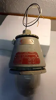

**VTG Appleton A-51 Vented Explosion-Proof Industrial Light - Man Cave Garage Bar**

Pre-Owned

$34.99

+$14.45 shipping



Item description from the seller:
Transform your space with this vintage Appleton Electric A-51 Vented Explosion-Proof Industrial
Light Fixture - a perfect addition to your man cave, industrial garage, or home bar decor! Crafted
by the reputable Appleton Electric Company, this fixture boasts a unique blend of industrial charm
and safety features. The vented design ensures both functionality and a touch of nostalgia, making
it an ideal choice for enthusiasts seeking authentic vintage decor. Key Features: Manufacturer &
Model: Appleton Electric Company, A-51 Series Vented. Material: Durable metal body, likely aluminum,
for corrosion resistance. Safety Certification: UL and CSA certified, meeting safety standards for
hazardous locations. Voltage & Lamp Support: Supports up to 300 volts, compatible with various lamp
types (up to 200 watts). Mounting Instructions: Clearly marked "MOUNT VERTICAL" for correct
installation. Condition: Displays signs of wear and age; the ribbed glass enclosure is intact.
Please note, there is a slight gap in the top seal, and it may not be completely watertight. Elevate
your space with industrial decor that tells a story. Whether it's for your man cave, garage, or home
bar, this Appleton A-51 Vented Light Fixture is a conversation starter. Picture the warm glow adding
character to your favorite hangout spot. Buy now and let the vintage industrial charm illuminate
your unique style

- [Listing link](https://www.ebay.com/itm/386723431936?itmmeta=01HSWCF86Z5RS0VFPPBGQGZD8Z&hash=item5a0a834600:g:9QwAAOSwpDlluDud&itmprp=enc%3AAQAJAAABEPHSNGyQoO8pN8WmNRMHCIlNDmpuUw3yIBE1EGfu6VylzD0sxM2rFFpzuAbB1qudD9ipViG8rb02Tf%2B5YuTSw59fy7hbFG1d049FkuglOBFTrLDp0q92EBU8lCS16CFpf3g6JhcqkGMCQ1WWJDGRmY4AnvJjS4gRH5Bqk5A8VsgwgfpNkJTH4Ub5%2B%2FzqWhNb%2FHTDzzkyVXRTBUdATEsjxil1kl9Z2rZQEzmrxpNqtrizQ7mPkTFbFDdpRRh%2FZUdV1au4ED0825l%2F659I2MOfl0GDVryUD%2F4g2G7%2BdUNlAuXKMcInUhRlGf5hEBpwm5%2BwJLYS85dcWRjtS0tspFkpg%2FCw74GGUSmpHgzCJRiLGWgE%7Ctkp%3ABk9SR9SDvYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/9QwAAOSwpDlluDud/s-l225.webp)

- eBay item number: 386723431936
----------------------------------------------------------------------------------------------------

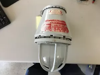

**APPLETON AP1550G EXPLOSION PROOF LIGHT FIXTURE**

New – Open box

$350.00

+$15.00 shipping



Item description from the seller:
APPLETON AP1550G EXPLOSION PROOF LIGHT FIXTURE WALL-12 M

- [Listing link](https://www.ebay.com/itm/163868905288?epid=4019404615&itmmeta=01HSWCF871V0RSTNFRSXPFW8SD&hash=item2627590f48:g:IgUAAOSwiT5dglZO&itmprp=enc%3AAQAJAAAA8El1VQJNUDO43ZcuC%2FJLSV3G4UsQ15iNvOuA5Arx3d%2BKMu43Q3vWwsCoYcLQC8CGnSgX1ZZThjU5l%2F%2BRoIAHxmfRtBxwBVvcibOhT8DlS9rsHBoDi8uKeQLrJcwErgn%2F%2BYvw2mj%2BRzmOeyOr3ONNtykWlp75eGFiiHx6y8mBDXCTsSWA9q2yoqVHOX5O1ZNCJSFQsgcBSsESy8L8Zi%2BqO01vfCynhN3AM8468e1FQ3sNVjjrex0Nww3%2BXZQqmqIo0EmMNLgojNhD7qtrq32E7yqW5JT2lM7YDVAGbP%2BXMRFd%2FoPYXnWOsK55pSpdEQL4FQ%3D%3D%7Ctkp%3ABk9SR9yDvYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/IgUAAOSwiT5dglZO/s-l225.webp)

- eBay item number: 163868905288
----------------------------------------------------------------------------------------------------

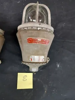

**VTG. 13" APPLETON ELECTRIC CO. EXPLOSION PROOF FACTORY LAMPS WITH CAGES $125 EA**

Pre-Owned

$117.00

+$20.00 shipping



Item description from the seller:
I have 2 fixtures, asking $125 each. These are vintage explosion proof light fixtures made by The
Appleton Electric Co. 300 V max. 150 watt max When ordering specify which fixture you would like
(see pictures). As of right now both are available

- [Listing link](https://www.ebay.com/itm/403584005053?itmmeta=01HSWCF8713PE3PC71GC025MSR&hash=item5df77b33bd:g:y7IAAOSwlThiS1pI&itmprp=enc%3AAQAJAAAA8N%2F2RmWMF%2BnHV2kcChl1NmMEvALpR%2FhyTkCDVKloyxPgZyGmZZ6VJfBQ8aGiOU5mdZAuI55vXAqmbFjCJ3VKqJxADbe4psQ1jcCNg315XFddf3pVNZbsa6FbhxV6V%2FJmhWrtC7%2FMKpGwtda6YCMTWt0%2FJpG4myeIu5Rq%2Bb2KrAIYXdmAXMwwY7pdKvdaiPPwIQVFAAp1vB6XcMI7uMW6cF0T1FaFL7KcKOoQKslljDNL9V7uPJFKEaUvms0BEQjMRdHlh5ews18CIy8gEAZb%2FGXewEqkp0Rbl281oAqhjbIKFvl%2F71FbdXMP7qmWrWdWeQ%3D%3D%7Ctkp%3ABk9SR96DvYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/y7IAAOSwlThiS1pI/s-l225.webp)

- eBay item number: 403584005053
----------------------------------------------------------------------------------------------------

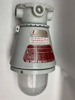

**Appleton,AAU-IN A-51 Series,Explosion Proof Light Fixture 100W**

New – Open box

$800.00

+$15.46 shipping



Item description from the seller:
New unused without original box NOS. Please see pictures for details and condition. You will receive
what’s in the pictures.  If we have multiples of the same item, the pictures may differ. Please
review the pictures to make sure the part number(s) match the item you are looking to replace. If
you notice that the part number in the listing, is different than what’s pictured, please contact us
so that we can fix it. Shipping: We offer USPS, FedEx, and freight shipping options.  OVERNIGHT
SHIPMENTS MUST BE PAID FOR BY 2PM EST for them to go same day. We ship to the address that is listed
on your eBay account, if the item is being shipped to a different address, please contact us
immediately so that we can get that shipped to the correct address. We ship Monday-Friday. All
weekend sales will be shipped on Monday. Returns: We have a 30 day hassle free return policy. All
return requests must be initiated within 30 days of date of receipt. Transactions outside of 30 Days
are not eligible for returns

- [Listing link](https://www.ebay.com/itm/325830974169?itmmeta=01HSWCF871V1J2D0Z0N4ED8FA8&hash=item4bdd0a1ad9:g:fKAAAOSw7ZdlFwO1&itmprp=enc%3AAQAJAAABEDV96hi3YCnkNHpRvhZtLQvYxhYwHDqrQerA3TIteG6o7%2BGes061QkMT6Qjvv6MrLfNDNnk8DcLzN76fWlp%2FlXloUYBlaU5i360cjeqdYP0Obq8crg6hRQxPag8%2BuvZLqT1QmPcunfSoFyYLLSjxHl1jCKJWeIFF4G8AweMkByZGBH3JDJNQ%2FhlQYpkkHmcPdU20Ca5W4vW2mlx5aG0gAca%2Fv52SgxzZnEWYTCqdOb9PoETbir5UHY8LPHZ5KNIOiGrxQH2yQM8gh5g0JJxi2uwRBza%2FIAOJ0zye18uzbv2oL%2FGYB%2Br90dA3oWJJtQD0NCPnauwQSKRwV5n6O%2BbIQPeW7%2Fs2ZNuqHY2qjnVXAHA0%7Ctkp%3ABk9SR96DvYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/fKAAAOSw7ZdlFwO1/s-l225.webp)

- eBay item number: 325830974169
----------------------------------------------------------------------------------------------------

In [14]:
query_number = 0
search_type_code = 1  # base results = 0, image results = 1
print_search_results(all_results, search_tasks, query_number, search_type_code)

Search for `Vintage Appleton explosion-proof light fixture high-quality industrial decor` returned 87 results

Top results based on **eBay's search engine**:


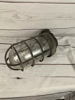

**Vintage Explosion Proof Appleton Form 200 Caged Light Vintage Industrial Light **

Pre-Owned

$5.50

+$9.62 shipping

Bid Status: 4 bids ·  - 1d 18h left



Item description from the seller:
I have a vintage Appleton form 200 shatter proof industrial light.  It's in working order has a nice
petina on it

- [Listing link](https://www.ebay.com/itm/315238138464?itmmeta=01HSWCHF0CJP4K6YA1KRST4S6D&hash=item4965a84260:g:UIgAAOSw7etl-13U&itmprp=enc%3AAQAJAAABADrAwVvpfGvAB0hvnjj%2B%2Brh3zEuFZ%2B2DqG3XRxkG52INlcUPDGNrekbwNyfs120mlGR%2FVJZyrFBZR8hhgHoHbEae9USe15m7OUMk6gUyApnvBPWpP3bj7FlmdwIE5FWrs%2B0WqIQljixEUazfLyqhbFq3dqeCtDVW2gIJZ0DiPv8TCRgnakHeGyUkptNZUCobKxzfT8wKbWu0WwTc2UVXMonwSpNb%2BKKIR5puTKqwXN9TLY5lwXCiuCDaXTRPsotIlbASTlLPPsBAyKQhw%2FVmaGfjcwaLHsE4imjshpL%2BCkojMGfcLacXAi%2FkCuxrfOxPQubM0RP2Yx7KtlTrp9bc%2B1I%3D%7Ctkp%3ABk9SR6LwxYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/UIgAAOSw7etl-13U/s-l300.webp)

- eBay item number: 315238138464
----------------------------------------------------------------------------------------------------

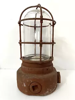

**Vtg Red Appleton Form 100-200 Explosion Proof Cage Light Fixture Steampunk**

Pre-Owned

$45.00

+$16.35 shipping



Item description from the seller:
You are purchasing a vintage Appleton Electric industrial cage light fixture.  It has a cool rust
red color.  There is surface wear throughout, see all photos. Please note it is untested and I am
not sure if the fixture is in working order or not.  The base is marked "Appleton Electric Co.
VXHA Unlit Form 100-200."   The porcelain light bulb socket is marked "Appleton Electric Company" &
"660 W - 250 V 550 W - 600 V."  The cage bulb guard is marked "Appleton."  When assembled the
fixture measures approximately 10 1/4" tall x 5" diameter base.  It measures 7lbs 14.5oz unpacked.
 It has such a great steampunk nautical look. I have multiple of these exact light fixtures.
 Message me if more than one is needed. Please contact me prior to purchasing with any questions.
SHIPPING: Domestically, I am offering FedEx Ground, UPS Ground, USPS Insured Priority Shipping &
USPS Ground Advantage

- [Listing link](https://www.ebay.com/itm/266728267524?itmmeta=01HSWCHF0CX33D0RZSVDMD9XZJ&hash=item3e1a3e5f04:g:aOkAAOSwNpdl-cpi&itmprp=enc%3AAQAJAAABAPHkk7EfiVEStsmqERNnKL2vcfWlZOGAN06W0nZ7ycPosbiBTQZODMoVbx%2FVGa%2F6Z4dS3dYgWJUuFuXUIrDfrlu7qa22%2FckKE%2B6CSrD1nsxdy%2FQzY41kgbOmlsCOM51pnH8ShJC3ttrWDYyltLMcrBFsVg4noxsxnXJhaL7Q%2B5taZ2y6m3ldp%2Fsqg1dbGGdx238O6TEXJUfk09Epes3IsSKT9f735ctiOXi%2BTiq2jbnY2SxmaC6pQ0zmX7KMTf6mWJp1DNA1SXhp0kiYvkRq1rGA1UQCbjsHTrTSyTSdSk3oD3mcJG%2BxV6X1zA%2FHX%2F%2B%2FQVhKsFEJUf3XOz74TTcjO9c%3D%7Ctkp%3ABk9SR6LwxYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/aOkAAOSwNpdl-cpi/s-l300.webp)

- eBay item number: 266728267524
----------------------------------------------------------------------------------------------------

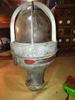

**Large vintage antique appleton Vented Explosion Proof Lighting Fixture steampunk**

Pre-Owned

$85.00

+$48.65 shipping

Bid Status: 0 bids ·  - 17h 30m left



Item description from the seller:
This large vintage antique Appleton lighting fixture is perfect for adding a touch of steampunk
style to any industrial lighting setup. Its vented design ensures safe operation in any facility,
making it an ideal choice for those in need of high-quality lighting fixtures for their business or
industrial space. With a brand name like Appleton, you can trust that this fixture is built to last
and will provide reliable lighting for years to come. Its unique vintage look is sure to draw
attention and add a touch of character to any space. Measures about 15 inches in lengt

- [Listing link](https://www.ebay.com/itm/166658150502?itmmeta=01HSWCHF0CV1QEMX4C76PN0TQ9&hash=item26cd999066:g:Y8IAAOSwgEpl1RBA&itmprp=enc%3AAQAJAAABACQZQUOAb6sz64MGbIaDTUKOl%2BTDGZnauNYIElGVvpiOlx%2FybjjaAVp1T3QaPgkD1RSKvqxEDHN1GI%2FaOfk7pSvh%2Fe%2Bae0olzGHezgP9v9WF%2FFTswM9%2Fll8Ks4nD%2FjhImGtD1LjGvHsUpZ%2FU4GQ79eNRE1y4UTJ1VRNWGXvN0B1PfS0WBuzMh1yrra0iCC8%2Bk7ZDrRR%2BNf4dqSXtA51WTnI2gIwTYew8EEEx8tPjeRnvzsH%2BAZB0wE%2B9tAcky7NpdkYHLxylZ4eA%2B3A0NIyyB1udVWegf%2FBBNkzqW1kbqraaeMMiL5h5wdoRqeQ2a0CpPZwgbS6H2nOC8mgAHvBklCY%3D%7Ctkp%3ABk9SR6LwxYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/Y8IAAOSwgEpl1RBA/s-l300.webp)

- eBay item number: 166658150502
----------------------------------------------------------------------------------------------------

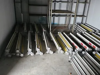

**Explosion Proof Light Fixture**

Pre-Owned

$250.00

+$94.97 shipping



Item description from the seller:
For sale are Rig-A-Lite explosion proof light fixtures is a great addition for any industrial
setting. Bulb Type: Fluorescen

- [Listing link](https://www.ebay.com/itm/364755388326?itmmeta=01HSWCHF0CBZC8ZG4QC0VEGHQX&hash=item54ed1d87a6:g:ufIAAOSwts1l02DD&itmprp=enc%3AAQAJAAABILDlK04Y7letRQZDt0ulZm7YYoNFpFgdMKCuYjGimdkrPy1N6X%2FP%2FRdenHJ9PUeso94KcK9%2F%2B%2Fu0AgIufsLqvvuf7G6vOyK2b2xK%2FjfMPkwZjFcxlywGgUHcTr1UhBDAYACUUKEw5utEVycEeEHm4Dr%2F8mEXua9tgmnjzdOt%2B0nOrHlZn0C1dsbcPAzuiYaOh1CjhjGrFtSOqtXuFQMH74lrPxldpPtHsWpMbFQpPGDLcEWa7RE8FQojY8bzPbmpqgf9XV1DotB043IzRvfZ1CpJd1VjRgHVCyQBhCCrbDW2FbNckJLucEq7kvAEWmvuvHB7TdxmQZOnWSk5osLJeR%2BjUkqFi%2FNi8gGzH5mqKrusw7ZVwFzVbVjyn7GQ7EYuGQ%3D%3D%7Ctkp%3ABk9SR6LwxYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/ufIAAOSwts1l02DD/s-l300.webp)

- eBay item number: 364755388326
----------------------------------------------------------------------------------------------------

In [17]:
query_number = 2
search_type_code = 0  # base results = 0, image results = 1
print_search_results(all_results, search_tasks, query_number, search_type_code)

In [41]:
combined_search_results = ""

for obj in filtered_chunks:
    combined_search_results += str(obj)
    combined_search_results += "\n"

In [42]:
print(combined_search_results)

**Vintage Warning Gas Pipeline Sign Gas Station Oil Phillips Texas Metal 12 Inch**

Pre-Owned

$75.00

Free shipping



Item description from the seller:

Vintage original sign-made of metal. Measures approx 12 inches. Shows some markings /  wear from use
but overall condition is great for display. Sold as is as shown no returns thanks enjoy! We have
hundreds of vintage and antique signs available. Please ask questions prior to purchase sold as is
as shown thank you enjoy

- [Listing link](https://www.ebay.com/itm/255513165876?itmmeta=01HYSN2RRX77QWV30JEQ2HNNDM&hash=item3b7dc58034:g:~eIAAOSwjzdibDVn&itmprp=enc%3AAQAJAAAA0EG5b4F8qifIWGa45nWZA46RnxKPKDuT7DGUq10gXmFPznfOEEJb6utZgW6ePWmnUCG71qokxOC8mBZ2q7x3it1%2B35XamgEIgmnnP0PkNARN8Q7tz%2BYCvG0lkHgJJ5z4Rmsqkb0%2BIQeBH6BDN%2F59%2BD9Rws%2BMX5ihOPMdtNqcOPsKcSArn5x9LHFZSc9WUlfr%2BOrx39jWkCVStxOAN6LRhkUDzVIxR383DksYgss1RWIS%2F6eyholUBg0%2FmrWhe4GQI5qgHE1DqV%2FBJSM6mbdYtVU%3D%7Ctkp%3ABk9SR8SMi7X2Yw)

- [Image link](https://i.ebayimg.com/thumbs/

In [3]:
from openai import AsyncAssistantEventHandler

def search_listings(query: str):
    """Run one eBay search query and return the top 10 results"""
    search_results = eBayWebSearch(query)
    output_string = ""
    for res in search_results[:9]:
        output_string += str(res)
    return output_string

ai = Assistant(
    instructions="You are a helpful research assistant, skilled at drafting engaging reports that are well structured and nicely formatted.",
    tools=[search_listings],
)
ai.say(
    f"Please analyze the ITEM DESCRIPTION and SEARCH RESULTS and use them to write a market research-style report. \
    Include in your report details on the top 5 SEARCH RESULTS that most closely resemble the DESCRIPTION. \
    Note that the SEARCH RESULTS contain a mix of text and image based searches. You can select from ANY of them to find the best matches.\n\nITEM DESCRIPTION: {initial_inspection}\n\nSEARCH RESULTS: {combined_search_results}",
    event_handler_class = AsyncAssistantEventHandler,
)



NameError: name 'initial_inspection' is not defined

In [56]:
messages = thread.get_messages()
pprint_messages(messages)

╭─ User ───────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│  Please analyze the ITEM DESCRIPTION and SEARCH RESULTS and use them to write a market           │
│  research-style report.     Include in your report details on the top 5 SEARCH RESULTS that      │
│  most closely resemble the DESCRIPTION.     Note that the SEARCH RESULTS contain a mix of text   │
│  and image based searches. You can select from ANY of them to find the best matches.             │
│                                                                                                  │
│  ITEM DESCRIPTION: # Vintage Gas Pipeline Warning Sign                                           │
│                                                                                                  │
│  This image depicts a vintage warning sign that is likely to have been used to mark the          │
│  location of a gas pipeline. Below is a detailed analysis of the sign's features and potential   │
│  value:                                                                                          │
│                                                                                                  │
│                                                                                                  │
│                                       Visual Description:                                        │
│                                                                                                  │
│   • Color Scheme: The sign features a striking color contrast with a black background, bold      │
│     yellow border, and red typeface, which are colors traditionally used for high visibility     │
│     and to denote caution.                                                                       │
│   • Typography: The word "WARNING" is prominently displayed in large, uppercase letters,         │
│     indicating the importance of the information provided.                                       │
│   • Graphics: Below the warning text, there is an illustration of a gas well tower and           │
│     construction machinery, which visually communicates the type of infrastructure associated    │
│     with the pipeline.                                                                           │
│   • Company Logo: At the bottom, the sign includes the name ASSOCIATED NATURAL GAS INC., which   │
│     is a specific identifier likely linked to the company that operated the gas pipeline.        │
│   • Contact Information: It provides contact numbers that would have been used for excavating    │
│     or in emergency situations, adding to its authenticity as a functional industrial sign.      │
│                                                                                                  │
│                                                                                                  │
│                                          Significance:                                           │
│                                                                                                  │
│   • Collectibility & Market: Vintage and antique signage is a popular category among             │
│     collectors, especially items that have industrial, transportation, or petroleum history      │
│     relevance.                                                                                   │
│   • Condition: The condition of the sign affects its value. In the image, the sign shows some    │
│     wear, particularly around the edges. This patina could be seen as a desirable feature for    │
│     age authenticity or as a detractor from its condition.                                       │
│   • Authenticity and Age: The style of the sign, including font and design, can suggest its      │
│     age. The phone number format with a collect call notice

╭─ Assistant ──────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│                                                                                                  │
│                    Market Research Report: Vintage Gas Pipeline Warning Sign                     │
│                                                                                                  │
│                                             Overview                                             │
│                                                                                                  │
│  This report evaluates a specific vintage gas pipeline warning sign and identifies the top five  │
│  comparable listings on platforms such as eBay. The vintage sign in question features notable    │
│  elements: a black background with yellow border and red typeface, the word "WARNING" in         │
│  prominent letters, an illustration of a gas well tower, the company name ASSOCIATED NATURAL     │
│  GAS INC., and contact information for emergency or excavation purposes.                         │
│                                                                                                  │
│                                     Top Comparable Listings:                                     │
│                                                                                                  │
│  🌆 ]8;id=391187;https://i.ebayimg.com/thumbs/images/g/oq8AAOSwsO1lRDCx/s-l140.webp\Image]8;;\                                                                                        │
│  🌆 ]8;id=17980;https://i.ebayimg.com/thumbs/images/g/fLAAAOSwEClj1~7R/s-l500.webp\Image]8;;\                                                                                        │
│  🌆 ]8;id=589190;https://i.ebayimg.com/thumbs/images/g/NMAAAOSw-I1mAwW~/s-l500.webp\Image]8;;\                                                                                        │
│  🌆 ]8;id=347696;https://i.ebayimg.com/thumbs/images/g/jxkAAOSwse9lRAqZ/s-l140.webp\Image]8;;\                                                                                        │
│  🌆 ]8;id=680632;https://i.ebayimg.com/thumbs/images/g/CCwAAOSwj61l3iJ3/s-l140.webp\Image]8;;\                                                                                        │
│   1 Vintage Warning Natural Gas Pipeline Metal Sign 12" Round Associated Natural Gas             │
│      • Price: $40.00 (Free shipping)                                                             │
│      • Description: This vintage 12-inch round warning sign is associated with Associated        │
│        Natural Gas Inc. Condition details encourage potential buyers to verify via the provided  │
│        images.                                                                                   │
│      • eBay Item Number: ]8;id=591619;https://www.ebay.com/itm/186148062407?itmmeta=01HYSQY6KG49NMRX74QBMQ7S63&hash=item2b574a04c7:g:oq8AAOSwsO1lRDCx&itmprp=enc%3AAQAJAAAA0Cvb9oFw5hN%2FfXJMTQGpmcQ4Vv%2BU8ilr6BD3rCuMbD6%2BW8o%2B4GweuDWszsFrfwtuVRA93sdLItHc4ZFefnKgmkfz7z9hI0omaBB0w9rsr%2F2pSvXiAVPetVvLvofK%2BklNPgU1WUyxAgxxxor607kjsaeFI%2FPPURdZOMomtjKIyyQAXhw4fxOanosrlscAoZGh5N%2BWYExsu836rDsf5hoyPSzSB8KuD%2BTz47tsORYKqSfi%2F%2B2U2iuHseQJ1kPRu3fpeDiYBUnenSvcP%2Bupx87%2Fn9g%3D\186148062407]8;;\                                                            │
│                                                                                                  │
│   2 Vintage Porcelain WARNING GAS PIPELINE SIGN ~ Warren Petroleum Company                       │
│      • Price: $49.99 (+$15.99 shipping)                                                          │
│      • Description: This sign, from Warren Petroleum Company, is noted for its 12-inch size and  │
│        porcelain enamel finish. Despite some signs of age, it rem

In [45]:
from src.utils.output import format_message_string

query_eval0 = thread.get_messages()
query_eval_message0 = format_message_string(query_eval0[-1])
Markdown(query_eval_message0)

# Market Research Report on Vintage Gas Pipeline Warning Signs

## Introduction
This report focuses on a market analysis for a vintage gas pipeline warning sign detailed in its description. The characteristics, significance, and potential value of the sign have been evaluated to determine its collectibility and market appeal. Furthermore, similar items currently listed for sale on eBay have been examined to identify the top 5 closest comparables and derive insights for pricing and market positioning.

### ITEM DESCRIPTION: Vintage Gas Pipeline Warning Sign
- **Color Scheme:** Black background, bold yellow border, red typeface indicating caution.
- **Typography:** "WARNING" prominently displayed in large, uppercase letters.
- **Graphics:** Illustration of a gas well tower and construction machinery.
- **Company Logo:** ASSOCIATED NATURAL GAS INC.
- **Contact Information:** Includes phone numbers for emergencies or excavating.
- **Condition:** Shows wear, adding authenticity but slightly affecting its condition.
- **Era:** Pre-1990s based on phone number format and style.
- **Demand drivers:** Industrial history, transportation, petroleum relevance.

## Top 5 Comparable Listings Analysis

**1. Vintage Porcelain GAS PIPELINE WARNING SIGN ~ Warren Petroleum Company**
   - **Price:** $49.95
   - **Shipping:** $15.99
   - **Description:** Original condition, 12" diameter, signs of age/weather exposure.
   - **Condition:** Good, visible wear indicative of age.
   - **[Listing Link](https://www.ebay.com/itm/204713009425?itmmeta=01HYSQAQHT46WZ07FVNBA49YT4&hash=item2fa9d8a111:g:NMAAAOSw-I1mAwW~)**
   - **[Image Link](https://i.ebayimg.com/thumbs/images/g/NMAAAOSw-I1mAwW~/s-l500.webp)**

**2. Vintage Porcelain WARNING GAS PIPELINE SIGN ~ Warren Petroleum Company**
   - **Price:** $49.99
   - **Shipping:** $15.99
   - **Description:** Similar to the previous listing, 12" diameter, signs of age/weather exposure.
   - **Condition:** Good, visibly aged.
   - **[Listing Link](https://www.ebay.com/itm/196313473780?itmmeta=01HYSQAQHTZKMD5KWA3TNMT05N&hash=item2db531e2f4:g:fLAAAOSwEClj1~7R)**
   - **[Image Link](https://i.ebayimg.com/thumbs/images/g/fLAAAOSwEClj1~7R/s-l500.webp)**

**3. Vintage Warning Natural Gas Pipeline Metal Sign 12" Round Texas Oil & Gas**
   - **Price:** $34.00
   - **Shipping:** None specified
   - **Description:** 12" diameter, round sign with signs of age.
   - **Condition:** Used, with some wear.
   - **[Listing Link](https://www.ebay.com/itm/335359629627?itmmeta=01HYSQAQHTDY3XET79E572RDK4&hash=item4e14fdd93b:g:jxkAAOSwse9lRAqZ)**
   - **[Image Link](https://i.ebayimg.com/thumbs/images/g/jxkAAOSwse9lRAqZ/s-l140.webp)**

**4. Vintage Gas Pipeline WARNING SIGN No Smoking / No Trespassing – Mississippi**
   - **Price:** $35.00
   - **Shipping:** $13.60
   - **Description:** Metal sign, approximately 14" x 12", Southern Natural Gas Company.
   - **Condition:** Some wear around edges, colors still bright.
   - **[Listing Link](https://www.ebay.com/itm/235450600505?itmmeta=01HYSQAQHT53P86FE9H685YESR&hash=item36d1f30c39:g:CCwAAOSwj61l3iJ3)**
   - **[Image Link](https://i.ebayimg.com/thumbs/images/g/CCwAAOSwj61l3iJ3/s-l140.webp)**

**5. WARNING Petroleum Pipeline Sign Buckeye Pipeline Co. Vintage Rare Ohio**
   - **Price:** $37.95
   - **Shipping:** $15.45
   - **Description:** Multi-color design, bold WARNING message, used condition.
   - **Condition:** Some wear, original advertising piece.
   - **[Listing Link](https://www.ebay.com/itm/315390363593?itmmeta=01HYSQAQHT2STT9YJN2WGM9RJN&hash=item496ebb07c9:g:TI8AAOSwxYFmUK-w)**
   - **[Image Link](https://i.ebayimg.com/thumbs/images/g/TI8AAOSwxYFmUK-w/s-l140.webp)**

## Insights and Valuation
The comparables highlight several key points that inform the market value and appeal of the vintage gas pipeline warning sign under review:

1. **Demand and Interest:** There is clear interest in such industrial signs, particularly those with recognizable company branding and noticeable age-related features.
2. **Pricing Range:** Comparable items typically range between $34 and $50, with shipping costs adding another $10-$20.
3. **Key Features for Value:**
   - **Authenticity:** Items that are assured to be original (non-reproductions) tend to command higher prices.
   - **Condition:** While some wear is expected and can add to the item's authenticity, extensive damage can negatively impact value.
   - **Brand Recognition:** Signs from well-known companies or specific regions can have increased desirability.

## Conclusion
The analyzed vintage gas pipeline warning sign is well-positioned in a market appreciating industrial history and collector's items. Given the condition and detailed features of the sign, positioning it with a price between $50 to $75, inclusive of shipping, should attract interest from relevant collectors. Emphasizing the sign’s authenticity, pre-1990s era features, and its historical context relating to the associated company will be key selling points.

Realizing higher value will depend on strategic listing, clear photography, and highlighting its unique attributes in relation to comparable items in the market.

In [ ]:
def prompt_one_to_many_image_input(
    prompt: str,
    base_img_path: str, 
    comp_image_paths: List[str],
    max_tokens: int = 520,
    model: str = "gpt-4-vision-preview",
) -> str:
    """
    Compares a base image against a list of comparison images using GPT-4 with vision capabilities.
    Handles both web URLs and local file paths for images.

    Args:
        base_img_path (str): The URL or local path of the base image to compare against.
        comp_image_paths (List[str]): A list of URLs or local paths for the comparison images.
        max_tokens (int): Maximum number of tokens to use in the API call.

    Returns:
        str: The response from the API call.
    """
    # Prepare the base image
    if is_url(base_img_path):
        base_img_content = {"type": "image_url", "image_url": {"url": base_img_path}}
    else:
        base_img_content = {"type": "image_url", "image_url": f"data:image/jpeg;base64,{encode_image_to_base64(base_img_path)}"}

    # Construct the messages payload with the base image
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt,
                },
                base_img_content
            ],
        }
    ]

    # Dynamically add comparison images to the messages payload
    for comp_image_path in comp_image_paths:
        if is_url(comp_image_path):
            comp_img_content = {"type": "image_url", "image_url": {"url": comp_image_path}}
        else:
            comp_img_content = {"type": "image_url", "image_url": f"data:image/jpeg;base64,{encode_image_to_base64(comp_image_path)}"}

        messages[0]["content"].append(comp_img_content)

    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=max_tokens,
    )
    return response_parser(response.model_dump())

In [ ]:
multi_image_comp_prompt = """
I'm planning to list the item in the first image on eBay and looking for good 'comps' to help determine the price. 
Please review and assess whether the following images are similar enough to use. 
Include the number positions, if any, for the best comps, a highly concise explanation as to why.
"""

test_mutiple_comps = llm.prompt_one_to_many_image_input(
    multi_image_comp_prompt,
    base_img_path=target_image,
    comp_image_paths=image_urls,
)
Markdown(test_mutiple_comps)

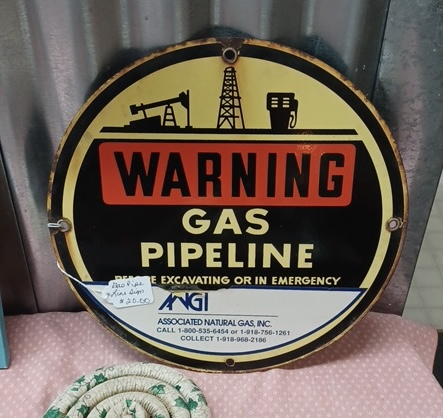

In [50]:
# target_image = "https://i.ebayimg.com/thumbs/images/g/9QwAAOSwpDlluDud/s-l300.jpg"
display(PILImage.open("ebay_item.jpg"))

In [53]:
import textwrap
import marvin
from pydantic import BaseModel, Field


class eBayListingItem(BaseModel):
    """An item for sale on eBay"""
    title: str = Field(description="A concise tag-line style title for the item.")
    item_specifications: str = Field(description="A detailed inspection of the item in the style of product details or technical specs.")
    seo_style_ebay_listing: str = Field(description="A SEO-focused compelling description of the item. It should be engaging to read, helping users imagine how the item could positively impact their life.")
    
    def __str__(self):
        wrapped_description = textwrap.fill(self.seo_style_ebay_listing, width=100)
        return f"## {self.title}\n\n**Item Description:**\n\n{wrapped_description}"
        

img = marvin.Image.from_path(
    "ebay_item.jpg"
)
result = marvin.cast(
    data=img, 
    target=eBayListingItem,
    instructions="You are a wold class eBay seller, an expert at vividly describing items and crafting irresistible listing descriptions.",
)

## Vintage Warning Gas Pipeline Sign

**Item Description:**

Add a touch of industrial charm to your space with this vintage 'Warning Gas Pipeline' sign. Made
from durable metal, this sign features bold yellow, black, and red colors that make a striking
statement. Measuring approximately 12 inches in diameter, it prominently displays the text 'WARNING
GAS PIPELINE' along with additional safety instructions. Manufactured by Associated Natural Gas,
Inc., this sign is not only a piece of history but also a unique decor item. Perfect for collectors,
industrial-themed rooms, or anyone looking to add a bit of vintage flair to their home or office.
Don't miss out on this rare find, available now for just $20.00!

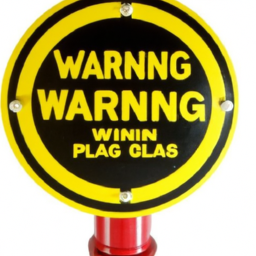

- Type: Warning Sign - Material: Metal - Diameter: Approximately 12 inches - Color: Yellow, Black,
Red - Text: 'WARNING GAS PIPELINE' - Additional Text: 'BEFORE EXCAVATING OR IN EMERGENCY' -
Manufacturer: Associated Natural Gas, Inc. - Contact Numbers: 1-800-453-6544, 1-918-786-1261,
1-918-968-2186 - Condition: Vintage, some signs of wear - Price: $20.00

In [54]:
image_test = llm.prompt_image_gen(
    prompt=str(result.seo_style_ebay_listing),
    model="dall-e-2",
    size_category="small",
    style="natural",
)
image_path = image_test.get('file_path')
display(Markdown(str(result)))
display(Image(filename=image_path))
wrapped_specs = textwrap.fill(result.item_specifications, width=100)
display(Markdown(f"{wrapped_specs}"))

In [25]:
# %%time
search_results = eBayWebSearch(search_tasks[0])
nest_asyncio.apply()
asyncio.run(process_ebay_images_with_async(search_results))
search_results = deduplicate_products(search_results)
df = pd.DataFrame([r.to_data_dict for r in search_results])
print(f"Found {len(search_results)} search results")
df.head(2)

Found 95 search results
CPU times: total: 203 ms
Wall time: 391 ms


,id,title,price,shipping,location,condition,text,listing_url,image_url,image_base64,image_uri,hash_id
0,315238138464,Vintage Explosion Proof Appleton Form 200 Cage...,$5.50,+$9.62 shipping,None,Pre-Owned,eBay\nI have a vintage Appleton form 200 shatt...,https://www.ebay.com/itm/315238138464?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/UIgAAOSw...,UklGRqoSAABXRUJQVlA4IJ4SAAAwZQCdASqpAOEAPm0wlE...,data\multimodal\Vintage_Explosion_Proof_Applet...,b8e6c30462593ad3572ae259ca679a9c
1,145405189978,APPLETON ELECTRIC EXPLOSION PROOF FLUORESCENT ...,$159.99,+$39.95 shipping,None,Parts Only,eBay\nVintage APPLETON ELECTRIC EXPLOSION PROO...,https://www.ebay.com/itm/145405189978?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/F8AAAOSw...,UklGRoAtAABXRUJQVlA4IHQtAAAQgACdASqpAOEAPm0okE...,data\multimodal\APPLETON_ELECTRIC_EXPLOSION_PR...,b94fcaaac3a2c696c0d868056149de29



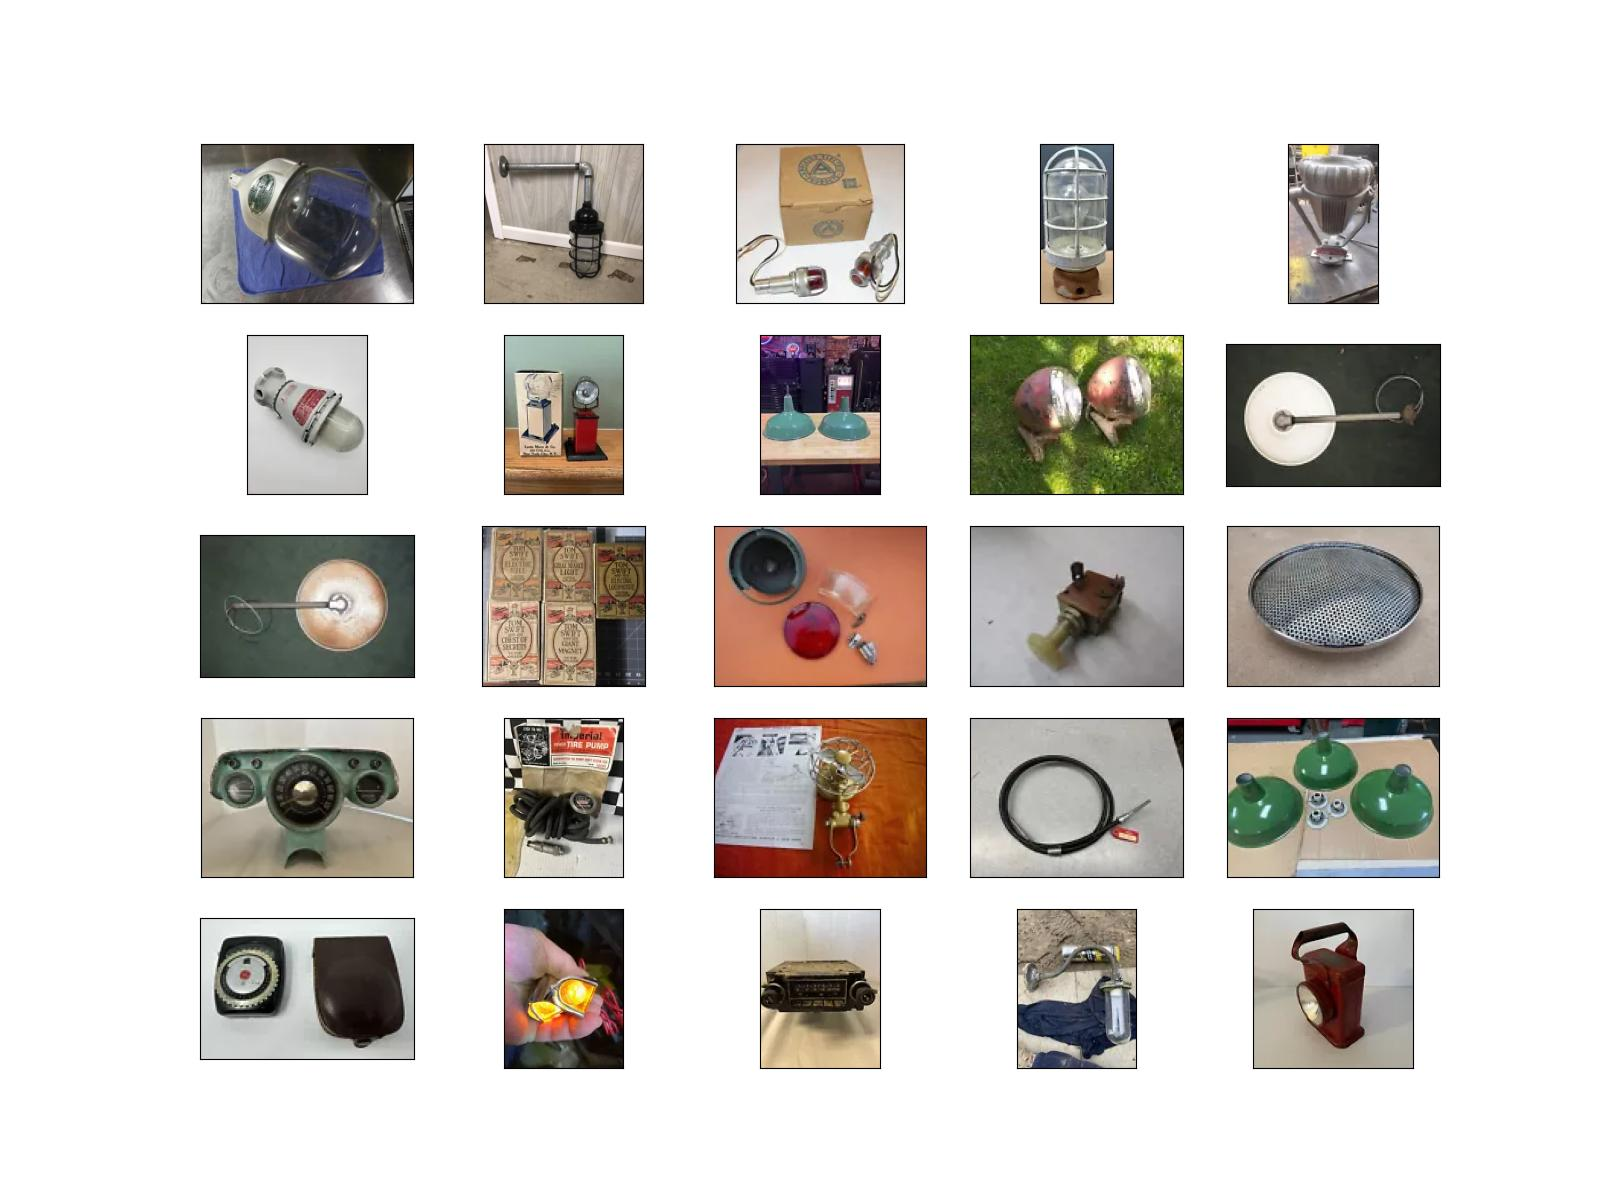

In [56]:
image_paths = [str(r.full_path) for r in search_results]
base64_image = plot_images(image_paths, './data/output_plot.jpg')
HTML(f'<img src="data:image/jpeg;base64,{base64_image}" />')

In [57]:
def search_image_vectors(image_path: str, df: pd.DataFrame):
    df["similarity_score"] = "0.0"
    db = lancedb.connect("./.lancedb")
    table = db.create_table("ebay", schema=eBayItems, mode='overwrite')
    table.add(df)
    # To to open the input as an image
    try:
        query = PILImage.open(image_path)
    # Fallback to text search
    except:
        query = str(image_path)
    rs = table.search(query) \
        .limit(100) \
        .to_pandas()
    rs["similarity_score"] = 1 - rs["_distance"]
    rs.sort_values(by="similarity_score", ascending=False, inplace=True)
    rs["similarity_score"] = rs["similarity_score"].astype('string')
    list_of_dicts = rs.to_dict(orient='records')
    return [eBayItems(**item) for item in list_of_dicts]

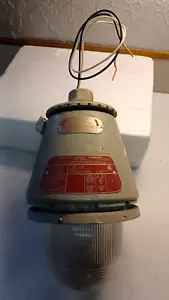

In [75]:
PILImage.open("test_image.jpg")

In [4]:
rs = search_image_vectors("test_image.jpg", df=df)

NameError: name 'search_image_vectors' is not defined

In [81]:
df = pd.DataFrame([r.to_data_dict for r in rs])
df.head(2)

,id,title,price,shipping,location,condition,text,listing_url,image_url,image_base64,image_uri,hash_id
0,226020546592,Appleton Electric Company A-51 GRF Explosion P...,$50.00,Free shipping,None,Pre-Owned,eBay\nAppleton Electric Company A-51 GRF Explo...,https://www.ebay.com/itm/226020546592?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/2RsAAOSw...,UklGRoYFAABXRUJQVlA4IHoFAADQHQCdASppAIwAPm00lU...,data\multimodal\Appleton_Electric_Company_A-51...,503f2e9ade3fe1a6c35752f388556d01
1,176255515396,VINTAGE GLASS LENS TILT UP TAIL LIGHT 20s 30s ...,$114.50,+$10.00 shipping,None,Pre-Owned,eBay\nThis is fresh from a local farm estate a...,https://www.ebay.com/itm/176255515396?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/lYIAAOSw...,UklGRvIGAABXRUJQVlA4IOYGAAAQKQCdASqMAGsAPpE+mU...,data\multimodal\VINTAGE_GLASS_LENS_TILT_UP_TAI...,e988c431b9f53079b073a47df0440489


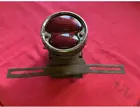

In [83]:
rs[1].image

* Using text to search images

100%|██████████| 59/59 [00:01<00:00, 30.18it/s]


**For  Mwill1930 1920s Hanging Chandelier**

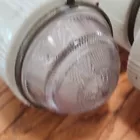

In [72]:
text_search = "lightbulb"
rs = search_image_vectors(text_search, df=df)
display(Markdown(f"**{rs[0].title}**"))
rs[0].image

100%|██████████| 59/59 [00:01<00:00, 30.91it/s]


**VTG Appleton Electric Industrial Submarine Uni Let Explosion Proof Wall Light**

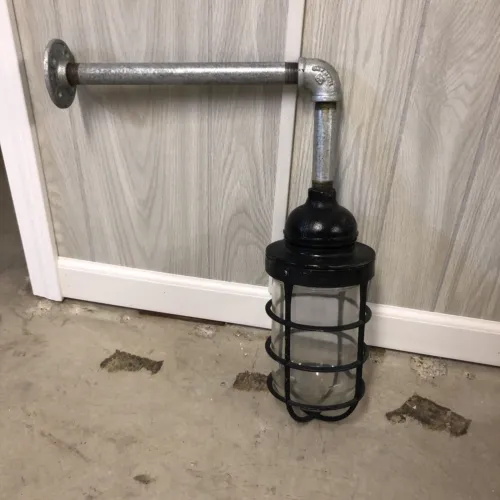

In [53]:
text_search = "Vintage Appleton Explosion-Proof Industrial Light Fixture"
rs = search_image_vectors(text_search, df=df)
display(Markdown(f"**{rs[0].title}**"))
rs[0].image

In [89]:
df.head(3)

,id,title,price,shipping,location,condition,text,listing_url,image_url,image_base64,image_uri,hash_id
0,226020546592,Appleton Electric Company A-51 GRF Explosion P...,$50.00,Free shipping,None,Pre-Owned,eBay\nAppleton Electric Company A-51 GRF Explo...,https://www.ebay.com/itm/226020546592?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/2RsAAOSw...,UklGRoYFAABXRUJQVlA4IHoFAADQHQCdASppAIwAPm00lU...,data\multimodal\Appleton_Electric_Company_A-51...,503f2e9ade3fe1a6c35752f388556d01
1,176255515396,VINTAGE GLASS LENS TILT UP TAIL LIGHT 20s 30s ...,$114.50,+$10.00 shipping,None,Pre-Owned,eBay\nThis is fresh from a local farm estate a...,https://www.ebay.com/itm/176255515396?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/lYIAAOSw...,UklGRvIGAABXRUJQVlA4IOYGAAAQKQCdASqMAGsAPpE+mU...,data\multimodal\VINTAGE_GLASS_LENS_TILT_UP_TAI...,e988c431b9f53079b073a47df0440489
2,266812690221,VINTAGE NOS TRICO VACUUM GM WINDSHIELD WIPER W...,$318.50,+$21.90 shipping,None,New (Other),eBay\n1955-1958 General Motors Windshield Wash...,https://www.ebay.com/itm/266812690221?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/0g4AAOSw...,UklGRkQMAABXRUJQVlA4IDgMAAAwNQCdASqMAGkAPm0sk0...,data\multimodal\VINTAGE_NOS_TRICO_VACUUM_GM_WI...,94d677c79294f34a27cdb3c7e3723301


In [279]:
import jinja2
import pdfkit


async def convert_html_to_pdf(
    html_string: str,
    image_url: str,
    template_folder: str = "./static",
    base_html_file: str = "base.html",
    output_file: str = "generate_pdf.pdf",
    output_folder: str = "./data",
) -> str:

    if output_folder.endswith("/"):
        raise ValueError("Wrong output folder name, should not end with '/'")
    else:
        pdf_file_name = f"{output_folder}/{output_file}"

    try:
        template_loader = jinja2.FileSystemLoader(template_folder)
        template_env = jinja2.Environment(loader=template_loader)

        basic_template = template_env.get_template(base_html_file)

        output_html_code = basic_template.render()
        # print(output_html_code)

        # render content, this if for once we have AI generated response
        output_html_code = basic_template.render(
            ai_generated_content=html_string,
            image_url=image_url,
        )

        options = {
            'page-size': 'A4',
            'margin-top': '0.75in',
            'margin-bottom': '0.75in',
            'margin-right': '0.55in',
            'margin-left': '0.55in',
            'encoding': "UTF-8",
            'footer-right': '[page] of [topage]',
            'footer-font-size': "9",
            'custom-header': [
                ('Accept-Encoding', 'gzip')
            ],
            'enable-local-file-access': False,
            'no-outline': None,
            'enable-local-file-access': False,
            'no-outline': None
        }

        pdfkit.from_string(
            input=output_html_code,
            output_path=pdf_file_name,
            options=options
        )

    except Exception as e:
        print(e)
        return ""

    return pdf_file_name

In [280]:
template_str = '''
<table class="poll-table">
  <thead>
    <tr>
      {% for c in columns %}
      <th>{{ c.title() }}</th>
      {% endfor %}
    </tr>
  </thead>
  <tbody>
     {% for row in rows %}
     <tr>
     {% for k, v in row.items() %}
      <td>
        {% if k == 'title' %}
        <!-- Link the title to the item's URL -->
        <a href="{{ row['listing_url'] }}" style="color: #000; text-decoration: none;">{{ v }}</a>
        {% elif k == 'listing_url' %}
        <!-- Skip rendering listing_url as it's already linked with title -->
        {% else %}
        {{ v }}
        {% endif %}
     </td>
     {% endfor %}
     </tr>
     {% endfor %}
  </tbody>
</table>

<style>
.poll-table {
  max-width: 960px; 
  width: 100%;
  border-collapse: collapse;
  font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;
  margin: 0 auto;
  box-shadow: 0 2px 3px rgba(0,0,0,0.1);
}

.poll-table th,
.poll-table td {
  page-break-inside: avoid; 
  border: 1px solid #ddd;
  padding: 10px 15px;
  text-align: left;
  font-size: 14px;
  border-left: none;
  border-right: none;
  overflow: hidden;
  text-overflow: ellipsis;
}

.poll-table th {
  background-color: #000;
  color: #fff;
  font-weight: bold;
  font-size: 24px;
  overflow: hidden;
}

.poll-table tr:nth-child(even) {
  background-color: #f9f9f9;
}

.poll-table tr:hover {
  background-color: #f1f1f1;
}

.poll-table tbody td {
  border-bottom: 1px solid #ddd;
}

.poll-table  {
  border: 1px solid #000;
}

.poll-table td:first-child,
.poll-table th:first-child {
  border-left: 1px solid #ddd;
}

.poll-table td:last-child,
.poll-table th:last-child {
  border-right: 1px solid #ddd;
}
</style>
'''

In [240]:
df["price"] = df['price'].str.replace("$", "＄")
df["price"] = df["price"].astype(float)
df.head(1)

,id,title,price,shipping,location,condition,text,listing_url,image_url,image_base64,image_uri,hash_id,similarity_score,item_price,item,title_link
0,315238138464,Vintage Explosion Proof Appleton Form 200 Cage...,5.5,+$9.62 shipping,None,Pre-Owned,eBay\nI have a vintage Appleton form 200 shatt...,https://www.ebay.com/itm/315238138464?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/UIgAAOSw...,UklGRqoSAABXRUJQVlA4IJ4SAAAwZQCdASqpAOEAPm0wlE...,data\multimodal\Vintage_Explosion_Proof_Applet...,b8e6c30462593ad3572ae259ca679a9c,0.0,5.5,5.5,"<a href=""https://www.ebay.com/itm/315238138464..."


In [257]:
def create_hyperlink(title: str, url: str) -> str:
    """
    Creates an HTML hyperlink with custom styling.

    Args:
        title (str): The display text for the hyperlink.
        url (str): The URL the hyperlink points to.

    Returns:
        str: An HTML string containing the hyperlink with custom styling.
    """
    return f'<a href="{url}" style="color: #2D3748; text-decoration: none;">{title}</a>'

# Apply the function to create a new column with HTML hyperlinks
df['Title'] = df.apply(lambda row: create_hyperlink(row['title'], row['listing_url']), axis=1)

In [282]:
from jinja2 import Template

template = Template(template_str)

html = template.render(
    rows=df[['Title', 'price', 'shipping', 'condition']].head(10).to_dict(orient='records'),
    columns=df[['Title', 'price', 'shipping', 'condition']].columns.to_list()
)

HTML(html)

Title,Price,Shipping,Condition
"<a href=""https://www.ebay.com/itm/315238138464?itmmeta=01HSWCF86Z58WBJQAEBBF8KTDG&hash=item4965a84260:g:UIgAAOSw7etl-13U&itmprp=enc%3AAQAJAAABEKkfAJ45%2FiI530Tfk%2F7wPNz83nY64IvoiQpzOInyo%2F0eCVHSWICArUvMOYQlFnlqA3oXzqiz1ado39NON9JaCALf93kdk%2B1C4qXmG3wk%2BJVEYRBrFn9Q8iaK9AduwGwHbhBHN9R%2FcqbX5Ri2EeScz79AmBAncNEhnD5lqQIY8sObX5CUtcto6vUeNYJCZ6zaLtPBf5TpT2Ms8%2FgPH7uVLxkQ6PYlm7IIjkHZ3cHtrXcz4AnAle69xth2XP7rRMXtfklzErne%2BsV7s9etIN2XhelWXKuC6MwZa3KhOBrYjFj9MXA10FHXym9xr93yvyGq4wvvs7OLtuS9pxDBz%2FGBvXUzOva0FuKv%2FbnpImnZnhUl%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">Vintage Explosion Proof Appleton Form 200 Caged Light Vintage Industrial Light",5.5,+$9.62 shipping,Pre-Owned
"<a href=""https://www.ebay.com/itm/145405189978?itmmeta=01HSWCF86Z5SYZP5T0FM18YJZ9&hash=item21dad31f5a:g:F8AAAOSw-ABkh03R&itmprp=enc%3AAQAJAAAA8CAsUXQ17a3RrBCALlL7xMKmFYfsv0INttoWKj3OKoGgDBY3nQjikFC5TnZE0P7DfR4F4uhSmxMugPnnAu9p%2BgNwMxkRcgWVdsz9ry6aCfmLvArTYmQk5%2Bx1jra%2BhPQKA7KMDskmtfOjAV1JfN%2BdoX0kBO6uPpdR8%2BZBkkMDiPzJpWvVVFtxYUfAAVCRgI10Jct4QPKtHxw1pr4G590TvJhR7%2FluWwOckxbcE1zCzdsUTdo5qfDJn7M5K3XvN7Or4xX3gCvZ4%2FbBSaXLXzaUxmsJMqk0Jx7vXU%2FkvFLAWr05x98pJ7JAcTn4LmxqW0LGWQ%3D%3D%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">APPLETON ELECTRIC EXPLOSION PROOF FLUORESCENT Industrial 2-Bulb LIGHT FIXTURE",159.99,+$39.95 shipping,Parts Only
"<a href=""https://www.ebay.com/itm/386723431936?itmmeta=01HSWCF86Z5RS0VFPPBGQGZD8Z&hash=item5a0a834600:g:9QwAAOSwpDlluDud&itmprp=enc%3AAQAJAAABEPHSNGyQoO8pN8WmNRMHCIlNDmpuUw3yIBE1EGfu6VylzD0sxM2rFFpzuAbB1qudD9ipViG8rb02Tf%2B5YuTSw59fy7hbFG1d049FkuglOBFTrLDp0q92EBU8lCS16CFpf3g6JhcqkGMCQ1WWJDGRmY4AnvJjS4gRH5Bqk5A8VsgwgfpNkJTH4Ub5%2B%2FzqWhNb%2FHTDzzkyVXRTBUdATEsjxil1kl9Z2rZQEzmrxpNqtrizQ7mPkTFbFDdpRRh%2FZUdV1au4ED0825l%2F659I2MOfl0GDVryUD%2F4g2G7%2BdUNlAuXKMcInUhRlGf5hEBpwm5%2BwJLYS85dcWRjtS0tspFkpg%2FCw74GGUSmpHgzCJRiLGWgE%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">VTG Appleton A-51 Vented Explosion-Proof Industrial Light - Man Cave Garage Bar",34.99,+$14.45 shipping,Pre-Owned
"<a href=""https://www.ebay.com/itm/266728267524?itmmeta=01HSWCF86ZE9D87HYQ5TSFA8HY&hash=item3e1a3e5f04:g:aOkAAOSwNpdl-cpi&itmprp=enc%3AAQAJAAAA8PHkk7EfiVEStsmqERNnKL2vcfWlZOGAN06W0nZ7ycPosbiBTQZODMoVbx%2FVGa%2F6Zz5PhZfkGj3nSr2cT0%2BC6fHoNNzCS3n843kyg0npd5cpZpIXtjj2JOv43arMfbhFzj%2FhGlN9noIkuf8xGRDyt8bZ2BPADw9%2Fk7RrgWrpvCDhxrCWQPSGvnw6Nju8cdh1B8d9IoMWbL3P075HaDsWK5jxU9nmjnqyywCBfeTUaO4VuKbWGP9rl34h6w4a3tw2UKfV2XB9B%2BOEbA4uSp5S9wNtBQKsSEZ1NKTERBjbhxai6Avnle5Wg%2Fh6IZgLimgvUQ%3D%3D%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">Vtg Red Appleton Form 100-200 Explosion Proof Cage Light Fixture Steampunk",45.0,+$16.35 shipping,Pre-Owned
"<a href=""https://www.ebay.com/itm/266737830306?itmmeta=01HSWCF86Z15V0CNTEY57N5RX7&hash=item3e1ad049a2:g:OFcAAOSwqCVmAgLT&itmprp=enc%3AAQAJAAABEC5z03LEcjxKRb6rxVN06h%2Bza%2BvfGh4epnwImrUECmbGKV%2BJsTteS2jwro5NM2ZPtDLw6y%2FSwD3fV9bUjX%2Fp%2FE52HlAzm3VBN25%2FoX12s6FPdRG1ovBOLWPTuHMBMivSTK4IQDHy%2BJC%2BKS%2FifzpZfD9HLOW0MOveFKvUAVpoysw4NLXFN4Axs6l5o%2Fsxn5MYm5A9yWgAigOxaCg1Frubdzsl0fQa4ZPUOcexyCaFCGly8AbvEmS0fQ5Hla7kpxbyCzxvdLAMEU1PQepJ6aheV9%2BKSc9tPdQHV%2BmRr6L%2FVHqm45ewYlnK4nUwSskSueo3DPC%2B4aACkF3tI5YAtBHZMqbu14n2kEYpUFSkxq7mB4As%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">New ListingThree (3) Appleton Electric Form 100 Explosion Proof Industrial Lights Caged",245.0,+$56.70 shipping,Pre-Owned
"<a href=""https://www.ebay.com/itm/296308287712?itmmeta=01HSWCF86ZNAJCTX8PZP6KJXY8&hash=item44fd59a8e0:g:m6cAAOSw~ZRl33G1&itmprp=enc%3AAQAJAAABEGCwhBRc4cX7485asBMcBh5lCGNDg4ounh3b5x59Tw%2FKa5HJEJXok9wABrh1kgTU46uf9aKmkwQiwQukMW%2BQbCgzHk8Y8kuOGhVEicHEqFpttXcPPQL7hxUzGAPAn3--iETzmmj8Rbpzk2bKX%2BYRExNHIiXlZ619YC7wtpI7fNLAQ1I3ALV1QfE7dEaVH3qg2cqqytgxxiHE4ysFQIuXqARtJvEpv68MSYClqEWx5uUUCC2VYeEJ635e6tSoh%2BWM6Jrl7Up0lEQqz%2FKBsahmaKPSMZunBxYxDz0VPTFbehlM2B76

In [295]:
import markdown
import nest_asyncio
nest_asyncio.apply()

text = initial_inspection + "\n\n\n\n" + avg_pricing_message_str + "\n\n" + query_eval_message0 + "\n\n" + results0 +  "\n\n" + results1 + "\n\n" + html

html_str = markdown.markdown(text, extensions=['pymdownx.magiclink'])

generated_pdf_file_name = asyncio.run(
    convert_html_to_pdf(
    html_string=html_str,
    image_url=target_image,
))